# 데이터 분석

## 라이브러리

In [1]:
# %pip install --upgrade pip

In [2]:
## 텍스트 처리
# !pip install JPype1-1.3.0-cp39-cp39-win_amd64.whl
# !pip install konlpy
## 통계검정
#!pip install pingouin

In [3]:
# import
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import pingouin as pg
from scipy.stats import mannwhitneyu

import re
import sys

import itertools
from collections import Counter

import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from konlpy.tag import Hannanum
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 그래프 한글폰트 출력을 위한 코드
def get_font_family():
    '''
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    '''
    import platform
    system_name = platform.system()
    # mac OS 일때
    if system_name == 'Darwin' :
        font_faimly = 'AppleGothic'
    # 윈도우일떄 
    elif system_name == 'Windows':
        font_family = 'Malgun Gothic'
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = 'NanumBarunGothic'

    return font_family

# style 설정은 꼭 폰트설정 위에서 한다. 
# style에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 깨진다.
# plt.style.use('seaborn')

#폰트설정
plt.rc('font', family=get_font_family())

#마이너스폰트 설정
plt.rc('axes', unicode_minus=False)

# 그래프에 retina display 적용
# 그래프 해상도 
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_format = 'retina'

# 기업리스트

## 데이터셋 불러오기

In [5]:
# 기업 리스트 csv 불러오기
df_company_list = pd.read_csv('./input/df_company_list.csv', index_col=0)
print(df_company_list.shape)
df_company_list.head(3)

(1201, 7)


,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
0,(주)티몬,50695,IT/웹/통신,서울,2022,2.8,4426
1,(주)위메프,60632,IT/웹/통신,서울,2003,2.6,2874
2,삼성에스디에스(주),30162,IT/웹/통신,서울,1801,3.5,8296


In [6]:
df_company_list.tail(3)

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
1198,콤위즈(주),91089,IT/웹/통신,서울,30,2.4,2794
1199,트럼피아(주),92889,IT/웹/통신,서울,30,2.0,4144
1200,한국옐로우페이지(주),90425,IT/웹/통신,서울,30,2.3,3058


## 기본정보 확인

### info

In [7]:
df_company_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1201 entries, 0 to 1200
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   회사명     1201 non-null   object 
 1   회사코드    1201 non-null   int64  
 2   업종      1201 non-null   object 
 3   본사위치    1201 non-null   object 
 4   리뷰수     1201 non-null   int64  
 5   평균별점    1201 non-null   float64
 6   평균연봉    1201 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 75.1+ KB


### 결측치

In [8]:
df_company_list.isnull().sum()

회사명     0
회사코드    0
업종      0
본사위치    0
리뷰수     0
평균별점    0
평균연봉    0
dtype: int64

### 중복값
- 회사명의 코드와 회사코드의 길이가 다르다
    - 중복되는 회사명 존재
    - 회사코드를 접미사로 달아서 처리

In [9]:
# 회사명 - 회사코드 unique수가 다르다
df_company_list.nunique()

회사명     1200
회사코드    1201
업종         1
본사위치      17
리뷰수      280
평균별점      35
평균연봉    1011
dtype: int64

In [10]:
# 중복되는 회사명 검색
df_company_list[df_company_list.duplicated(subset='회사명')]

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
529,(주)데이타솔루션,86935,IT/웹/통신,서울,79,2.8,3556


In [11]:
# 중복데이터 전체 확인
df_company_list[df_company_list['회사명']=='(주)데이타솔루션']

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
484,(주)데이타솔루션,89732,IT/웹/통신,서울,87,2.6,3839
529,(주)데이타솔루션,86935,IT/웹/통신,서울,79,2.8,3556


In [12]:
# 중복데이터 + 접미사(회사코드) 처리
df_company_list['회사명'] = df_company_list.apply(lambda x: x['회사명']+'_'+ str(x['회사코드']) if x['회사명']=='(주)데이타솔루션' else x['회사명'], axis=1)

In [13]:
# 회사명 nunique 변경
df_company_list.nunique()

회사명     1201
회사코드    1201
업종         1
본사위치      17
리뷰수      280
평균별점      35
평균연봉    1011
dtype: int64

In [14]:
# 변경 완료
cond = df_company_list['회사명'].str.contains('데이타솔루션')
df_company_list[cond]

,회사명,회사코드,업종,본사위치,리뷰수,평균별점,평균연봉
index,,,,,,,
484,(주)데이타솔루션_89732,89732,IT/웹/통신,서울,87,2.6,3839
529,(주)데이타솔루션_86935,86935,IT/웹/통신,서울,79,2.8,3556


### 기타
- IT기업 데이터만 추출했으므로 `업종` 컬럼 제거
- `회사코드` 제거 

In [15]:
df_company_list.drop(['회사코드','업종'], axis=1, inplace=True)

## 분석

- 서울,경기 지역에 본사가 밀집되어있다 (전체의 94% 이상)
    - 잡플래닛 리뷰데이터가 30개 이상인 IT기업 기준

In [16]:
grouped = df_company_list.value_counts('본사위치',normalize=True).reset_index(name='prop.')
grouped['누적'] = grouped['prop.'].cumsum()
grouped.head(5)

,본사위치,prop.,누적
0,서울,0.810991,0.810991
1,경기,0.129892,0.940883
2,대구,0.011657,0.952540
3,부산,0.010824,0.963364
4,대전,0.010824,0.974188


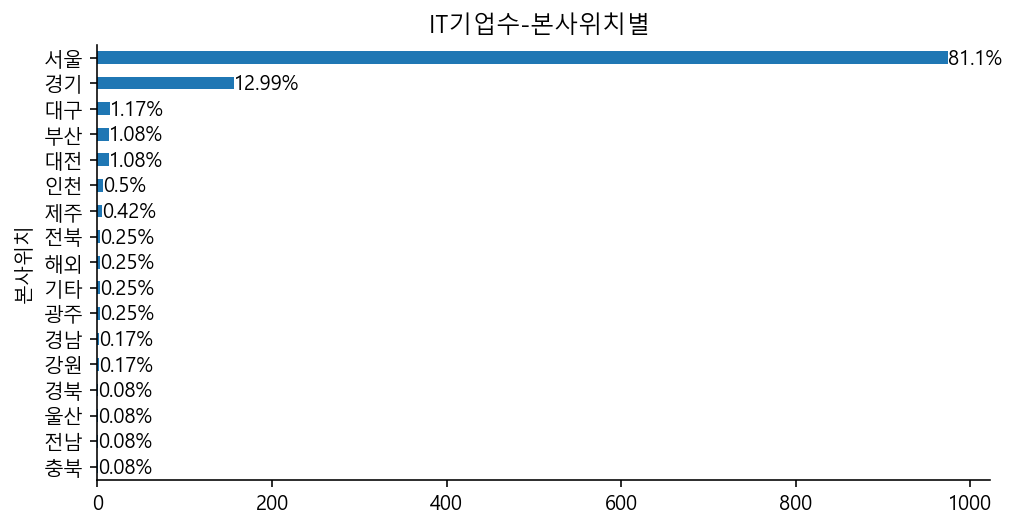

In [17]:
#시각화
plt.figure(figsize=(8,4))
grouped = df_company_list.value_counts('본사위치').sort_values()
g = grouped.plot(kind='barh')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df_company_list)*100,2)}%', (val, bar.get_y()))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.title('IT기업수-본사위치별 ')
plt.show()

- `평균별점`과 `평균연봉` 사이에 약한 양의 상관관계 존재

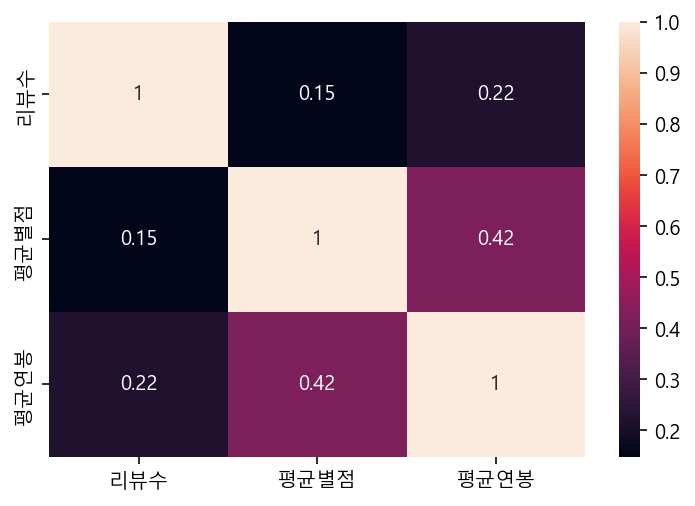

In [18]:
sns.heatmap(df_company_list.corr(), annot=df_company_list.corr());

- 기업의 평균연봉이 높을 수록 평균별점이 높아지는 경향 보인다.

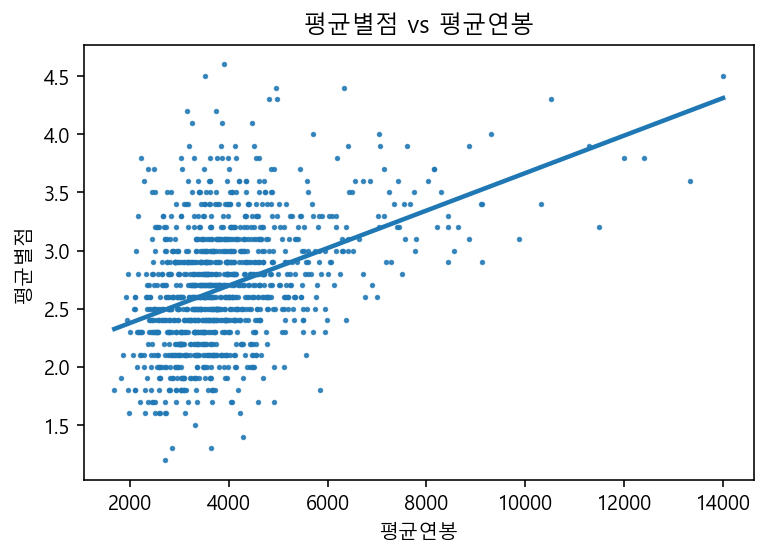

In [19]:
df = df_company_list
y='평균별점'
x='평균연봉'

sns.regplot(y=y,x=x, data=df, ci=None, scatter_kws={'s':3})
plt.title('평균별점 vs 평균연봉');

In [20]:
order = df.groupby(['본사위치'])['평균별점'].mean().sort_values(ascending=False).index

🔥
- 평균연봉이 낮은데 평점이 높은 회사는 어떤 곳인가?
- 반대로 평균연봉이 높은데 평점이 낮은 경우는?
- 특정 기업의 경우 평점조작 의혹이 있는 경우도 있음
    - 평점 조작은 어떻게 찾아내나?

In [21]:
df_company_list.sort_values('평균별점')

,회사명,본사위치,리뷰수,평균별점,평균연봉
index,,,,,
404,디자인커뮤니케이션(주),서울,100,1.2,2718
880,(주)세이퍼존,대전,44,1.3,3639
786,(주)아이네임즈,경기,51,1.3,2853
731,헤이코리안(주),서울,56,1.4,4298
965,아이리시스(주),서울,40,1.5,3311
...,...,...,...,...,...
1092,(주)센드버드코리아,서울,34,4.4,4946
666,라이엇게임즈코리아,해외,62,4.4,6337
1185,(주)살다,서울,30,4.5,3518


# 리뷰데이터

## 데이터셋 불러오기

- 데이터 갱신(스크레이핑 에러 없는 버전으로 갱신)

In [22]:
df_reviews = pd.read_csv('./input/df_reviews.csv', index_col=0,  low_memory=False)
print(df_reviews.shape)
df_reviews.head(3)

(148821, 19)


,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
0,티몬,50695,마케팅/시장조사,전직원,서울,2022. 04,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0
1,티몬,50695,영업/제휴,현직원,서울,2022. 04,3,5,5,5,1,1,"영업부서는 그나마 운영이 잘되나, 별 의미없는 콘텐츠 제작관련한 리소스가 너무 들...",연차사용 자유 / 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화. \n영...,동기부여도지 않는 모든것 ? / 2~3년 다니고 경험쌓기는 좋음 MD권한 많음\n대...,"신규사업을 하려면 청사진부터 그리고 방향성에 맞게 가이드라인을 만들고, 인사팀의 권...",비슷,추천,0
2,티몬,50695,디자인,현직원,서울,2022. 04,2,1,1,2,1,1,하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진,리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...,있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...,사업에 대한 비전과 그를 실현시킬 수 있는 구체적인 방향을 제시해주길 원합니다모두가...,NaN,비추천,0


In [23]:
df_reviews.tail(3)

,회사명,회사코드,직군,전/현직원 구분,근무지역,작성월,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,,
148818,한국옐로우페이지,90425,마케팅/시장조사,전직원,서울,2015. 08,2,2,2,2,2,2,공공기관 아래에서 중소기업을 돕는 업무는 진행하는 회사,공공기관 및 협회 업무에 대해서 직간접적인 경험을 할 수 있음,"직원의 희생에 대해서 당연시하는 경향 있으며,그 때문에 퇴사가 많은 편",회사를 발전시키고 싶다면 우선 직원의 삶이 발전해야 한다는 것을 알아야 함,비슷,비추천,3
148819,한국옐로우페이지,90425,기타,현직원,서울,2015. 03,2,3,2,2,1,2,중소기업과 가까이 일하는 회사.,국내 다양한 중소기업을 접해볼 수 있는 기회가 됨,요즘은 모르겠는데 예전엔 업무는 많은데 사람이 별로 없어서 힘들었음,업무배분이 효율적이면 좋을 것 같아요.,비슷,비추천,2
148820,한국옐로우페이지,90425,기타,전직원,서울,2014. 11,2,2,3,2,2,2,외국인 이면 들어가기 힘듭니다.마케팅 관심 필요,번역 알바생 으로 일을해봤는데 이주일에 하루만 근무,짧은 시간 동안 많은 양으로 번역 해야되기 때문에 스트래스 많이 받습니다,별로 추천하지 않습니다. 야근 준비 해야함,비슷,비추천,0


## 기본정보 확인

### info

In [24]:
df = df_reviews.copy()

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148821 entries, 0 to 148820
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   회사명          148821 non-null  object
 1   회사코드         148821 non-null  int64 
 2   직군           148649 non-null  object
 3   전/현직원 구분     148821 non-null  object
 4   근무지역         145610 non-null  object
 5   작성월          148730 non-null  object
 6   별점           148821 non-null  int64 
 7   승진 기회 및 가능성  148821 non-null  int64 
 8   복지 및 급여      148821 non-null  int64 
 9   업무와 삶의 균형    148821 non-null  int64 
 10  사내문화         148821 non-null  int64 
 11  경영진          148821 non-null  int64 
 12  총평           148820 non-null  object
 13  장점           148821 non-null  object
 14  단점           148821 non-null  object
 15  경영진에 바라는 점   148733 non-null  object
 16  1년 후 기업 전망   104781 non-null  object
 17  기업 추천여부      148821 non-null  object
 18  게시글 추천 수     148821 non-null  int64 
dtypes:

### 결측치

In [26]:
df.isnull().sum()

회사명                0
회사코드               0
직군               172
전/현직원 구분           0
근무지역            3211
작성월               91
별점                 0
승진 기회 및 가능성        0
복지 및 급여            0
업무와 삶의 균형          0
사내문화               0
경영진                0
총평                 1
장점                 0
단점                 0
경영진에 바라는 점        88
1년 후 기업 전망     44040
기업 추천여부            0
게시글 추천 수           0
dtype: int64

- 1년 후 기업 전망 데이터가 비어있는 경우가 많다.

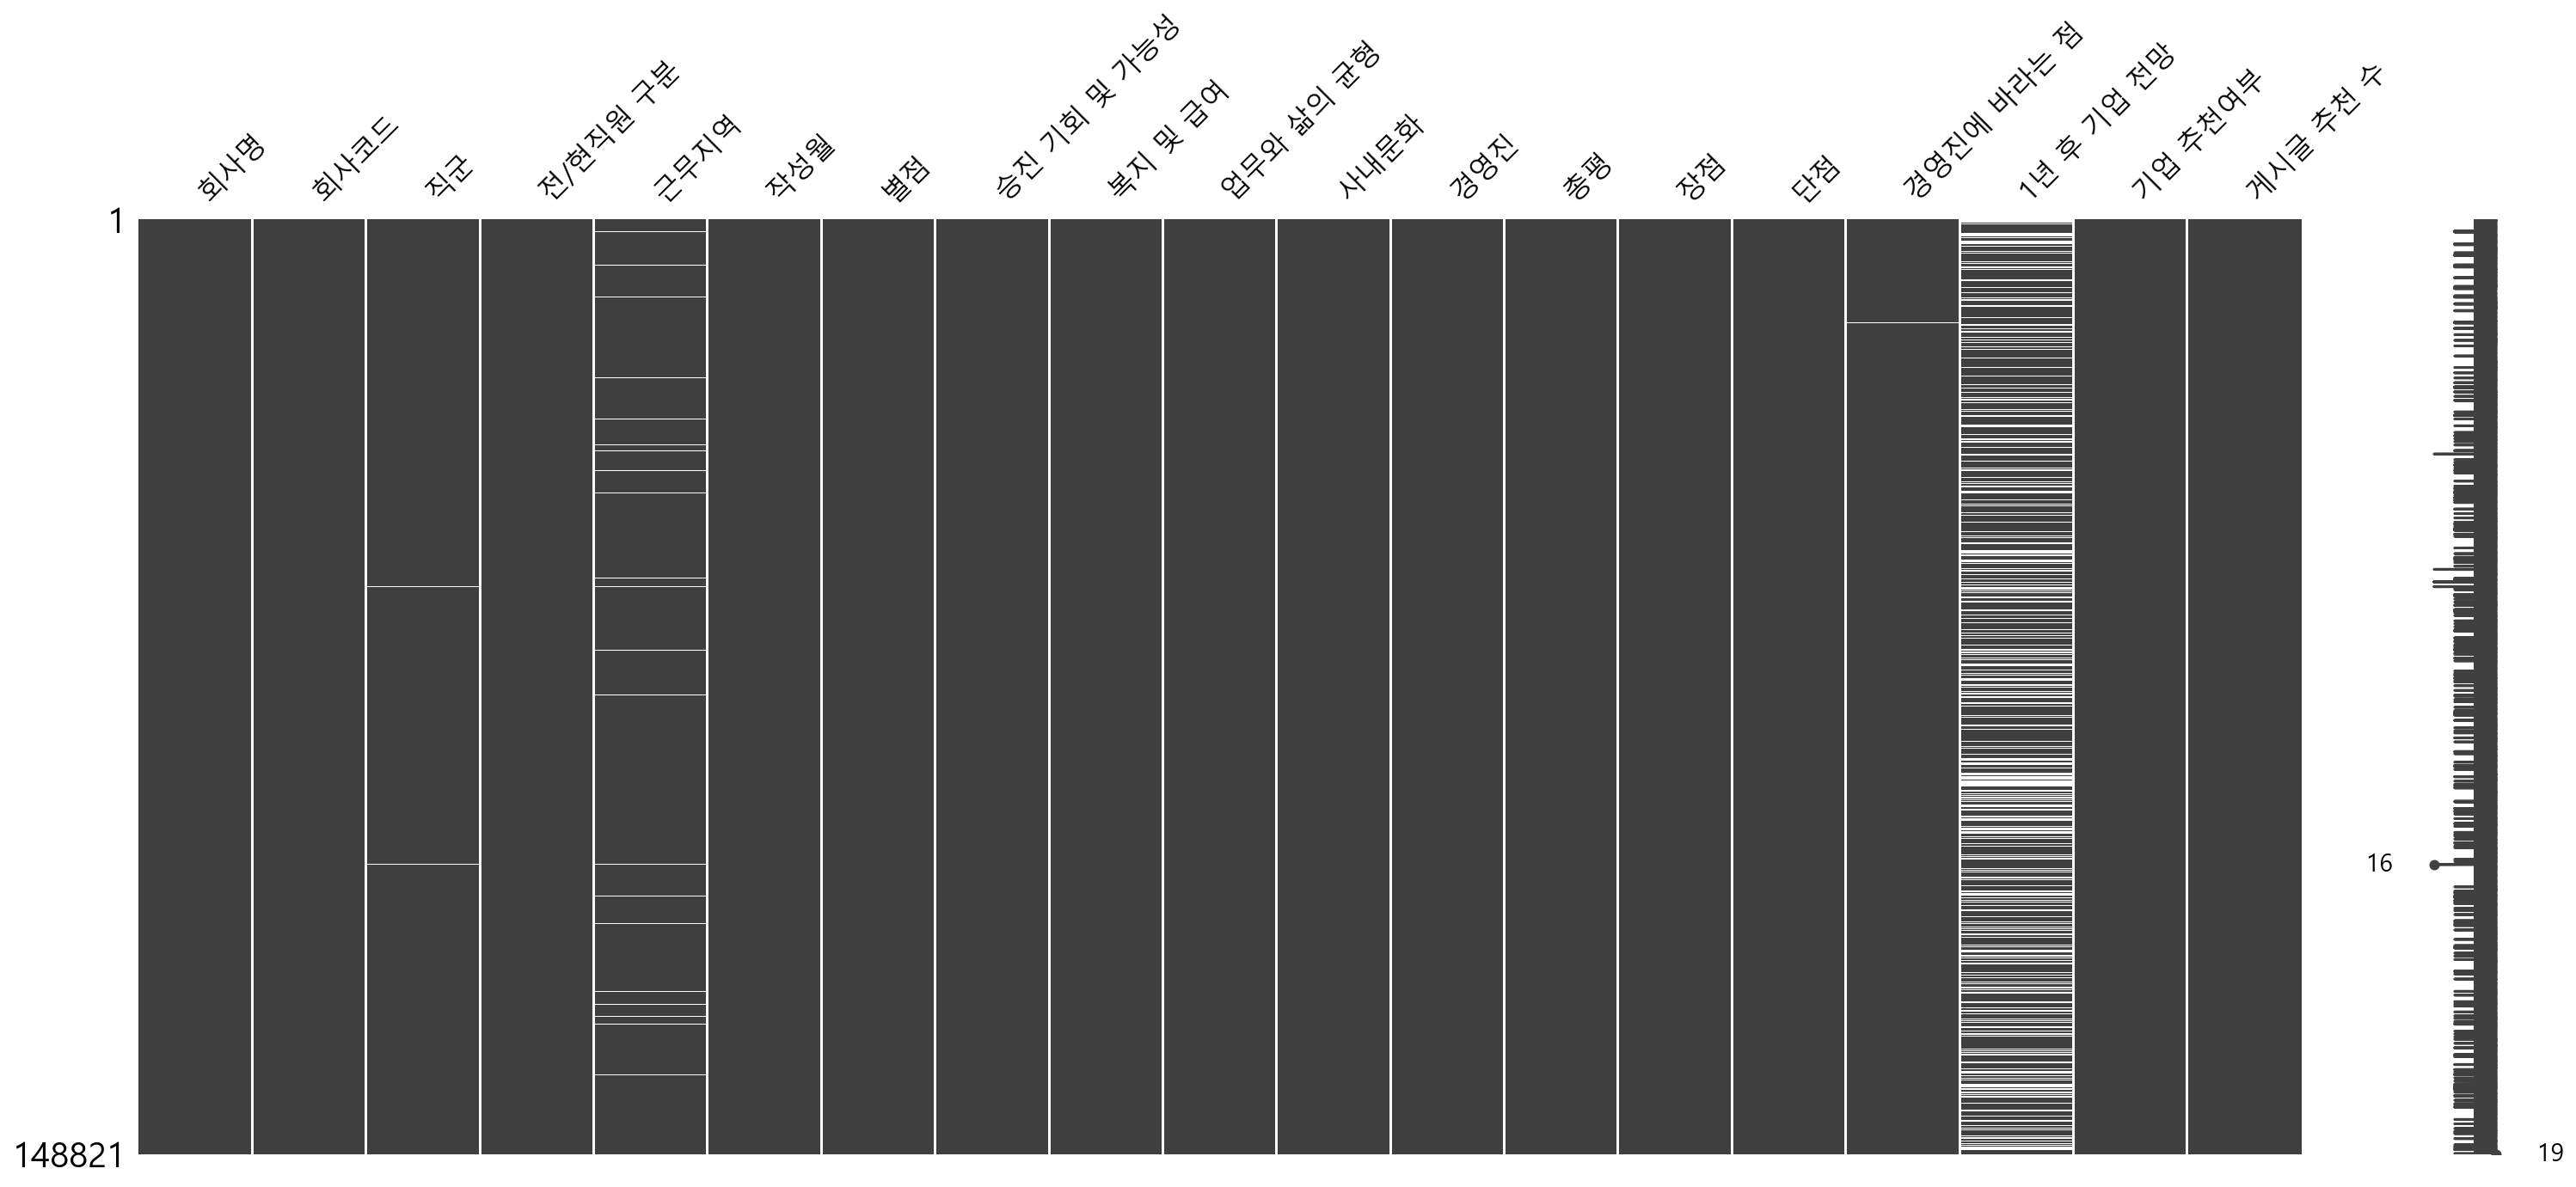

In [27]:
msno.matrix(df);

- 결측치 unknown 대체

In [28]:
df = df.fillna('unknown')
df.isnull().sum()

회사명            0
회사코드           0
직군             0
전/현직원 구분       0
근무지역           0
작성월            0
별점             0
승진 기회 및 가능성    0
복지 및 급여        0
업무와 삶의 균형      0
사내문화           0
경영진            0
총평             0
장점             0
단점             0
경영진에 바라는 점     0
1년 후 기업 전망     0
기업 추천여부        0
게시글 추천 수       0
dtype: int64

### 중복값

- 스크레이핑 과정에서 중복값 8개 발생 -> 제거

In [29]:
df.duplicated().sum()

8

In [30]:
# 중복값 제거
print('제거 전:',df.shape)
df = df.drop_duplicates()
print('제거 후:',df.shape)

제거 전: (148821, 19)
제거 후: (148813, 19)


- 하기 총 4개 기업에 대하여 회사코드를 접미사로 붙여 중복값문제 해결
    - 데이타솔루션 -> 기업리스트와 똑같은 문제
    - (주)유시스, 유시스(주) -> (주) 제거되면서 해당 문제 발생

In [31]:
grouped = df.groupby(['회사명','회사코드']).size().reset_index().drop(0, axis=1)
grouped[grouped.duplicated('회사명', keep=False)]

,회사명,회사코드
126,데이타솔루션,86935
127,데이타솔루션,89732
759,유시스,59945
760,유시스,59946


In [32]:
# 중복값되는 회사명에 접미사 추가 
df['회사명'] = df.apply(lambda x: x['회사명']+'_'+ str(x['회사코드']) if x['회사명']=='데이타솔루션' or x['회사명']=='유시스' else x['회사명'], axis=1)

In [33]:
grouped = df.groupby(['회사명','회사코드']).size().reset_index().drop(0, axis=1)
grouped[grouped.duplicated('회사명', keep=False)]

,회사명,회사코드


In [34]:
# 변경된 회사명 확인
df[df['회사명'].str.contains('데이타솔루션')]['회사명'].unique()

array(['데이타솔루션_89732', '데이타솔루션_86935'], dtype=object)

In [35]:
df[df['회사명'].str.contains('유시스')]['회사명'].unique()

array(['유시스_59946', '유시스_59945'], dtype=object)

### 기타 
- `회사코드` 제거

In [36]:
df.drop('회사코드', axis=1, inplace=True)

## 전처리

### `직군`

- 'IT-인터넷' -> 'IT/인터넷' 으로 통일

In [37]:
df['직군'].unique()

array(['마케팅/시장조사', '영업/제휴', '디자인', 'IT/인터넷', '서비스/고객지원', '경영/기획/컨설팅',
       '유통/무역', '생산관리/품질관리', '교육', '미디어/홍보', '인사/총무', '금융/재무', '생산/제조',
       '전문직', '법률/법무', '기타', '연구개발', '엔지니어링', '의약', '특수계층/공공', 'IT-인터넷',
       'unknown'], dtype=object)

In [38]:
df['직군'] = df['직군'].apply(lambda x:x.replace('-','/') if not isinstance(x, float) else x)
df['직군'].unique()

array(['마케팅/시장조사', '영업/제휴', '디자인', 'IT/인터넷', '서비스/고객지원', '경영/기획/컨설팅',
       '유통/무역', '생산관리/품질관리', '교육', '미디어/홍보', '인사/총무', '금융/재무', '생산/제조',
       '전문직', '법률/법무', '기타', '연구개발', '엔지니어링', '의약', '특수계층/공공', 'unknown'],
      dtype=object)

### `작성월`
- 불량 데이터 -> 결측치 변환 
    - '이 기업의 댓글' -> 'unknown'

In [39]:
df['작성월'].unique()

array(['2022. 04', '2022. 03', '2022. 02', '2022. 01', '2021. 12',
       '2021. 11', '2021. 10', '2021. 09', '2021. 08', '2021. 07',
       '2021. 06', '2021. 05', '2021. 04', '2021. 03', '2021. 02',
       '2021. 01', '2020. 12', '2020. 11', '2020. 10', '2020. 09',
       '2020. 08', '2020. 07', '2020. 06', '2020. 05', '2020. 04',
       '2020. 03', '2020. 02', '2020. 01', '2019. 12', '2019. 11',
       '2019. 10', '2019. 09', '2019. 08', '2019. 07', '2019. 06',
       '2019. 05', '2019. 04', '2019. 03', '2019. 02', '2019. 01',
       '2018. 12', '2018. 11', '2018. 10', '2018. 09', '2018. 08',
       '2018. 07', '2018. 06', '2018. 05', '2018. 04', '2018. 03',
       '2018. 02', '2018. 01', '2017. 12', '2017. 11', '2017. 10',
       '2017. 09', '2017. 08', '2017. 07', '2017. 06', '2017. 05',
       '2017. 04', '2017. 03', '2017. 02', '2017. 01', '2016. 12',
       '2016. 11', '2016. 10', '2016. 09', '2016. 08', '2016. 07',
       '2016. 06', '2016. 05', '2016. 04', '2016. 03', '2016. 

In [40]:
# 스크레이핑 에러 제거
df['작성월'] = np.where(df['작성월']=='이 기업의 댓글', 'unknown', df['작성월'])
df['작성월'].unique()

array(['2022. 04', '2022. 03', '2022. 02', '2022. 01', '2021. 12',
       '2021. 11', '2021. 10', '2021. 09', '2021. 08', '2021. 07',
       '2021. 06', '2021. 05', '2021. 04', '2021. 03', '2021. 02',
       '2021. 01', '2020. 12', '2020. 11', '2020. 10', '2020. 09',
       '2020. 08', '2020. 07', '2020. 06', '2020. 05', '2020. 04',
       '2020. 03', '2020. 02', '2020. 01', '2019. 12', '2019. 11',
       '2019. 10', '2019. 09', '2019. 08', '2019. 07', '2019. 06',
       '2019. 05', '2019. 04', '2019. 03', '2019. 02', '2019. 01',
       '2018. 12', '2018. 11', '2018. 10', '2018. 09', '2018. 08',
       '2018. 07', '2018. 06', '2018. 05', '2018. 04', '2018. 03',
       '2018. 02', '2018. 01', '2017. 12', '2017. 11', '2017. 10',
       '2017. 09', '2017. 08', '2017. 07', '2017. 06', '2017. 05',
       '2017. 04', '2017. 03', '2017. 02', '2017. 01', '2016. 12',
       '2016. 11', '2016. 10', '2016. 09', '2016. 08', '2016. 07',
       '2016. 06', '2016. 05', '2016. 04', '2016. 03', '2016. 

- 년.월 -> 년도 only로 처리
- 컬럼명 변경 
    - '작성월' -> '작성년도'

In [41]:
df['작성월'] = df['작성월'].apply(lambda x:x.split('. ')[0])
df = df.rename(columns={'작성월':'작성년도'})
df.head(1)

,회사명,직군,전/현직원 구분,근무지역,작성년도,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수
index,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0


In [42]:
df['작성년도'].unique()

array(['2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015',
       '2014', 'unknown'], dtype=object)

## 분석

### `직군`

- IT/인터넷 직군이 전체 리뷰 작성자의 58.15% 차지 
    - IT직군 여부에 따른 점수 차이 있을까?
- 다음으로 경영/기획/컨설팅, 영업/제휴 순

🔥
- 상세직군이 나오면 분석이 더 용이할것 같은데, 상세하게 적으면 누군지 추적이 되니까 상세하게 기재하지 못할 것 같다. 
- 직군을 가짜로 기재한 경우도 있을까?

In [43]:
grouped = pd.DataFrame(df['직군'].value_counts())
grouped['비율(%)'] = df['직군'].value_counts(normalize=True).round(4)*100
grouped.head(10)

,직군,비율(%)
IT/인터넷,86541,58.15
경영/기획/컨설팅,12138,8.16
영업/제휴,10124,6.80
마케팅/시장조사,9725,6.54
디자인,7920,5.32
서비스/고객지원,7364,4.95
미디어/홍보,3141,2.11
인사/총무,1977,1.33
금융/재무,1692,1.14
교육,1559,1.05


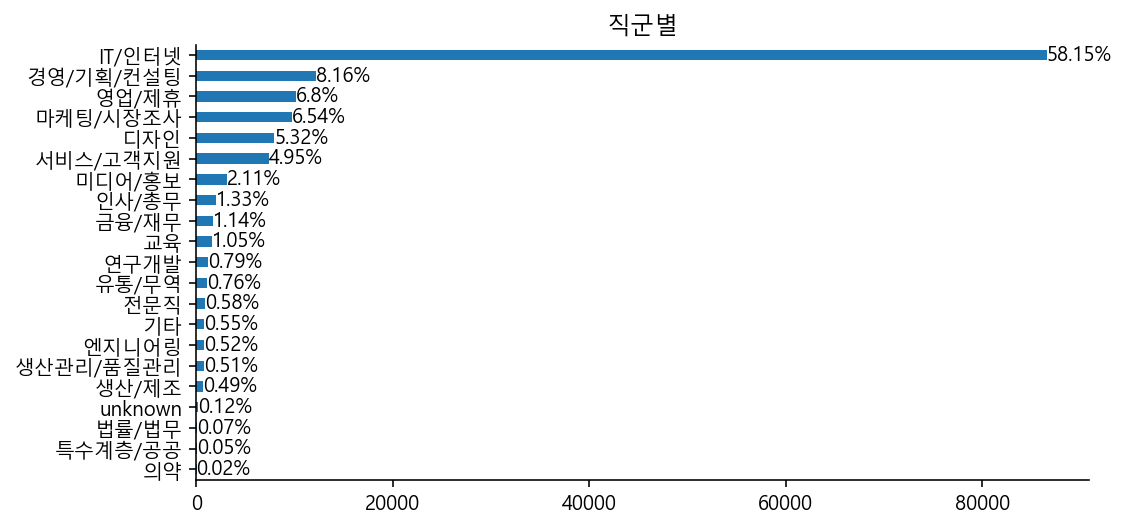

In [44]:
#시각화
x = '직군'
grouped = df['직군'].value_counts().sort_values()

plt.figure(figsize=(8,4))
g = grouped.plot(kind='barh')

# 수치 기입
for bar, val in zip(g.patches, grouped.values):
    g.annotate(f'{round(val/len(df)*100,2)}%', (val, bar.get_y()))

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


plt.title('직군별')
plt.show()

- IT직군 vs 비 IT직군 평균 점수 차이가 날지?

In [45]:
# IT여부 컬럼 생성
cond = df['직군'] == 'IT/인터넷'
df['IT여부'] = np.where(cond, 'IT', '비IT')
df.head(1)

,회사명,직군,전/현직원 구분,근무지역,작성년도,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부
index,,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0,비IT


In [46]:
# count plot 함수
def countplot(hue):
    g = sns.countplot(data=df, x=hue)

    for p in g.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(df))
        x = p.get_x() + p.get_width()
        y = p.get_height()
        g.annotate(percentage, (x-0.4, y), ha='center', va='bottom')
    
    sns.despine()
    plt.title(f'{hue}에 따른 평균 점수')
    plt.show()

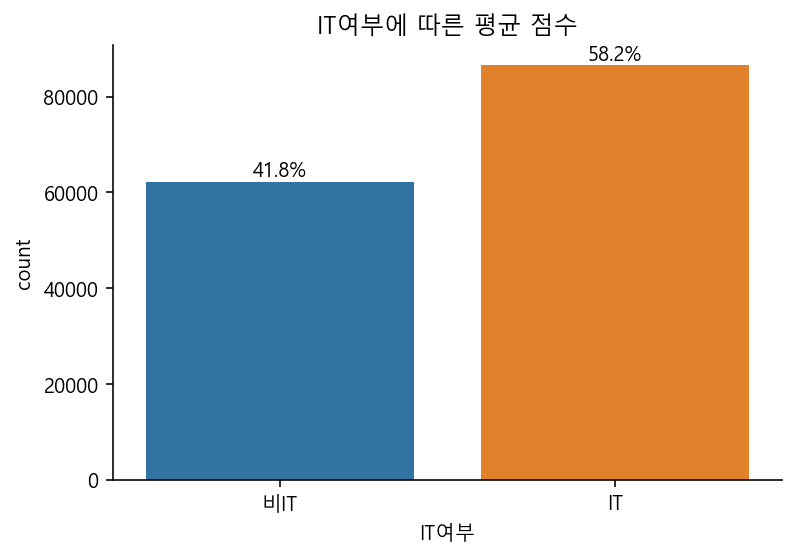

In [47]:
countplot('IT여부')

- histplot
    - 경영진에 대한 정

In [48]:
# histplot 생성함수 생성
arr_scores = ['별점', '승진 기회 및 가능성', '복지 및 급여', '업무와 삶의 균형', '사내문화', '경영진']
def histplot(hue=None):
    fig,ax = plt.subplots(2, 3, figsize=(15,7))
    for idx, col in enumerate(arr_scores):
        x = col
        r,c = idx//3, idx%3
        g = sns.histplot(x=x, data=df, discrete=True, hue=hue, ax=ax[r,c], 
                         stat="density", common_norm=False)
        if hue == None: g.set_title(col)
        else: g.set_title(f'{hue}에 따른 - {col} 분포')
        
    plt.tight_layout()
    plt.show()

- 6가지 항목에 대한 점수분포
    1. 모든 항목에서 5점에 대한 분포가 가장 적다. 
    2. 경영진 점수가 1점이 매우 높다.
        - 서비스 이용자 연령대와 상관이 있을까?
        - 20~30대 사용자가 주 사용자로 추측되는데 경영진에 대한 불만이 많아서?

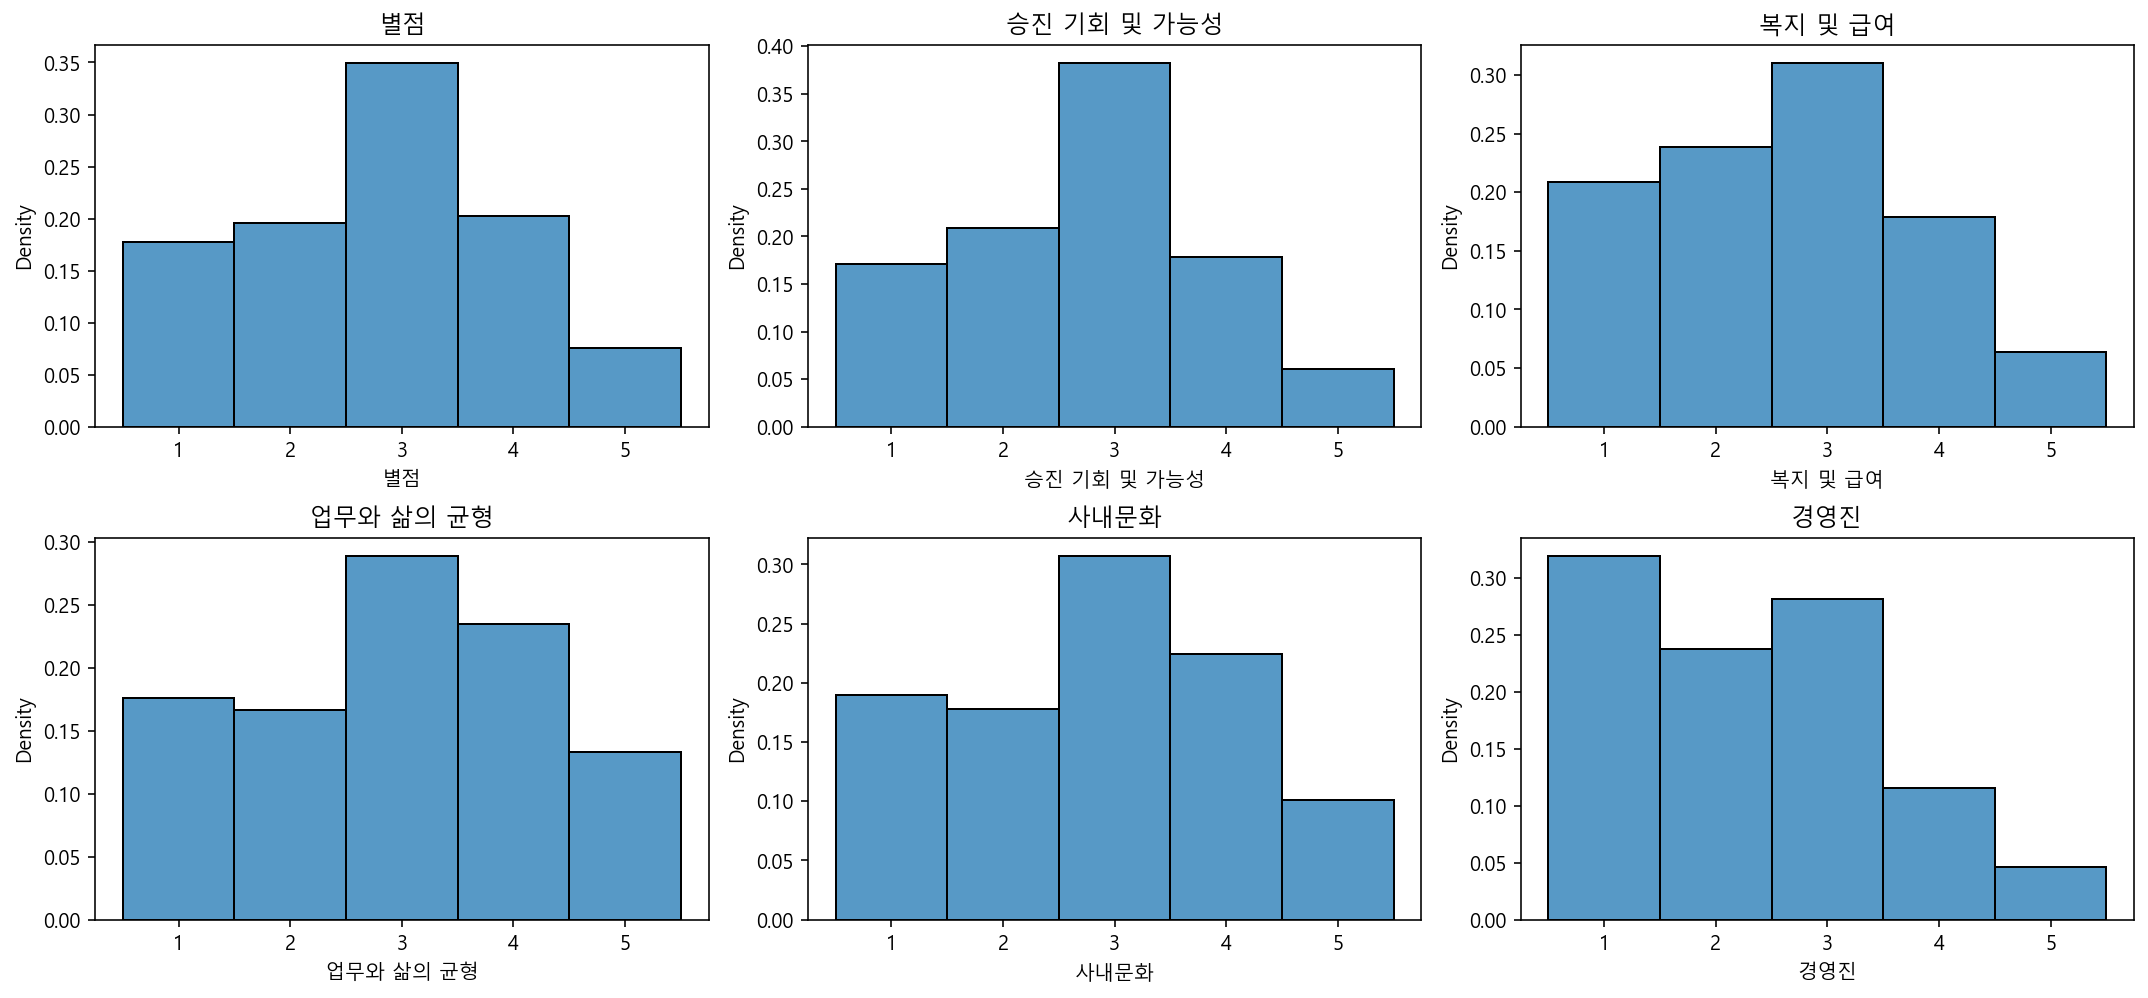

In [49]:
histplot()

- IT직군 여부에 따른 점수 분포
    - IT 직군
        - 경영진에 대한 불만(1~2점)이 비 IT직군에 비해 더 크다
    - 비IT직군
        - 승진 기회 및 가능성 / 업무와 삶의 균형 2가지 항목에서 1점의 분포가 더 크다.

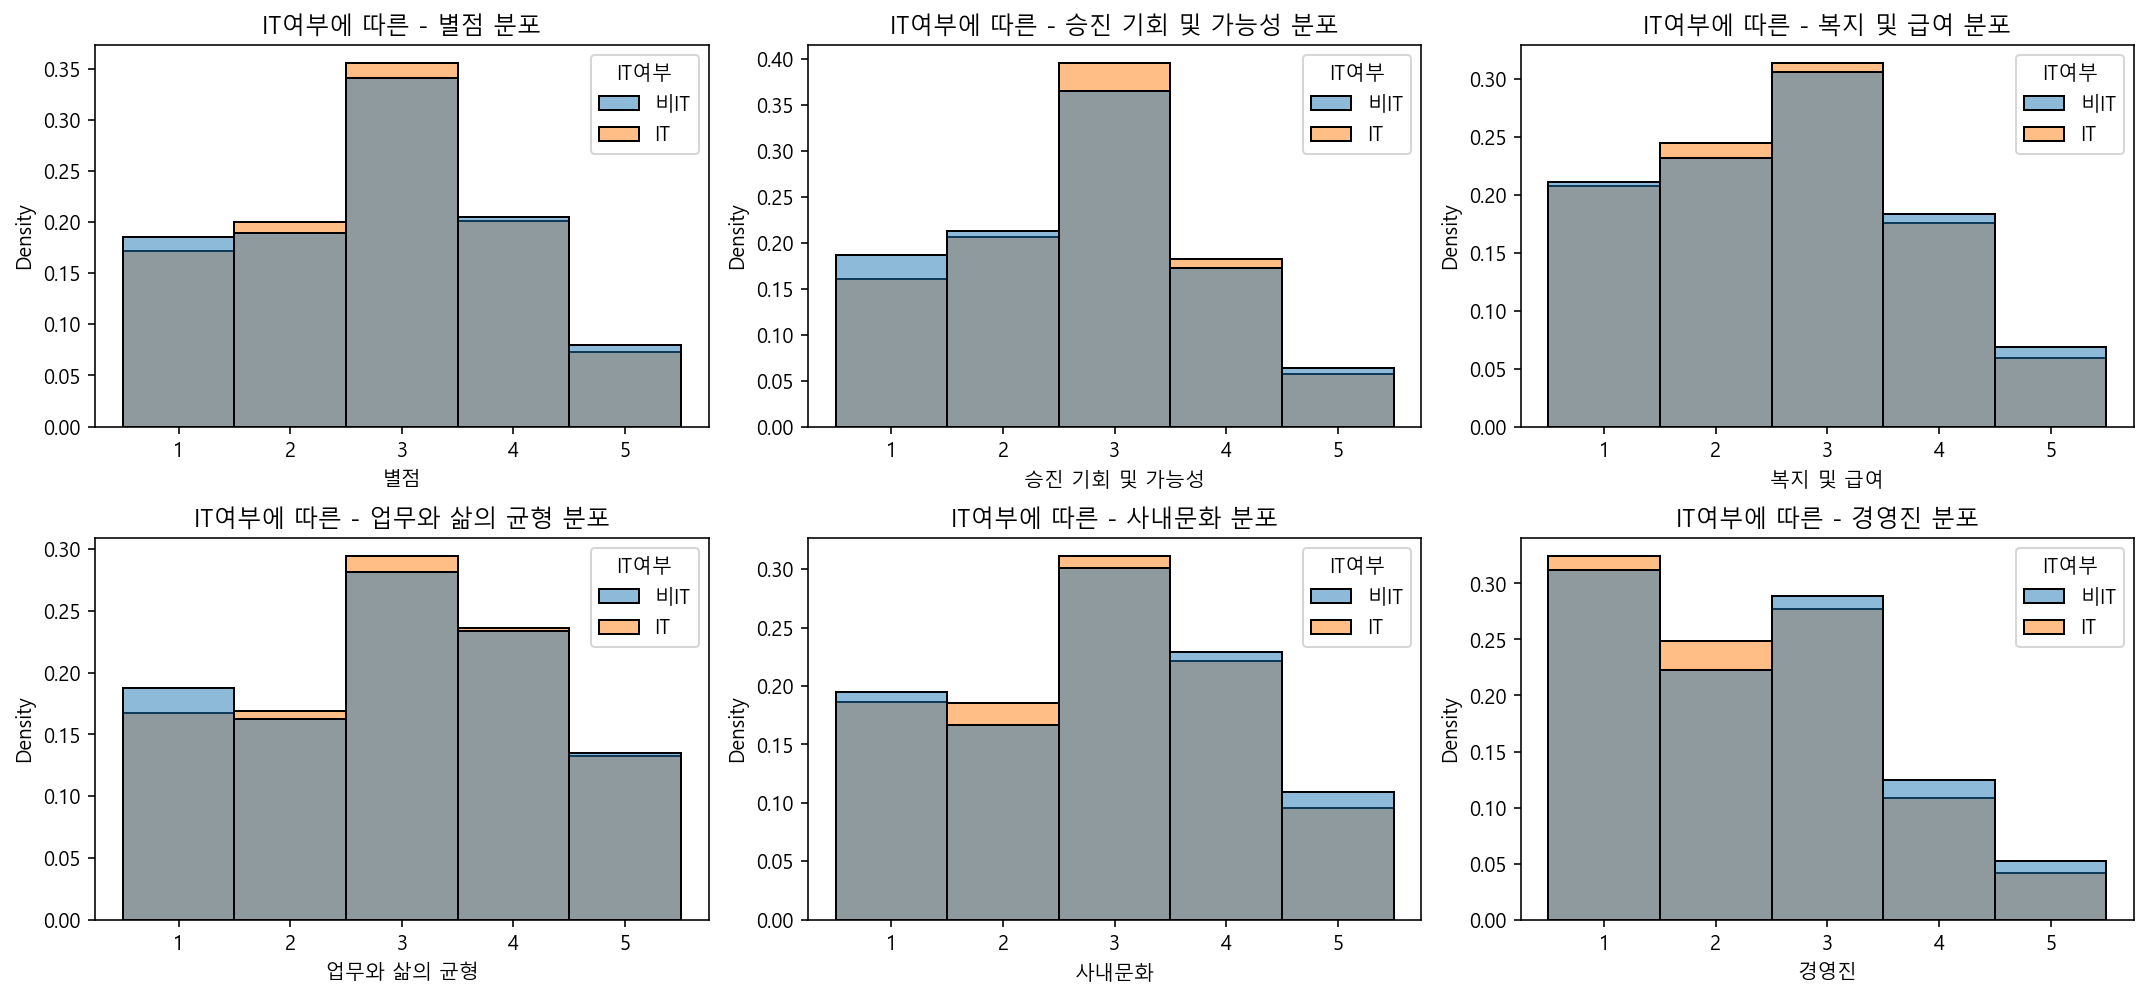

In [50]:
histplot('IT여부')

In [51]:
# melting table 함수 생성 
arr_scores = ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']
def melting_table(id_vars, value_vars=arr_scores):
    tmp = df[[id_vars]+value_vars]
    melted = tmp.melt(id_vars=id_vars, value_vars=value_vars, var_name='항목', value_name='점수')
    return melted

In [52]:
melted = melting_table('IT여부')
grouped = melted.groupby(['IT여부','항목'])['점수'].mean().reset_index()
grouped.head(6)

,IT여부,항목,점수
0,IT,경영진,2.295918
1,IT,별점,2.803226
2,IT,복지 및 급여,2.635814
3,IT,사내문화,2.854635
4,IT,승진 기회 및 가능성,2.771507
5,IT,업무와 삶의 균형,2.997377


- point plot
    - 별점의 차이는 크게 보이지 않고
    - IT직군의 승진기회 및 워라밸 평균점수가 높고,
    - 복지 및 급여, 사내문화, 경영진에 대한 점수는 낮다.
        - IT직군의 급여가 비IT직군에 비해 높을텐데 복지 및 급여점수가 더 낮은게 의외다.
        - IT vs 비IT 연봉 비교 테이블 구할 수 있으려나
        - 사내문화와 경영진에 대한 점수가 더 낮은건 왜 그런가?

In [83]:
# point plot 생성함수
def pointplot(hue=None):
    melted = melting_table(hue)
    grouped = melted.groupby([hue,'항목'])['점수'].mean().reset_index()
    g = sns.pointplot(data=grouped, y='점수',x='항목', hue=hue, order=arr_scores)
    plt.title(f'{hue}에 따른 평균 점수')
    plt.xticks(rotation=20)
    sns.despine()
    plt.show()

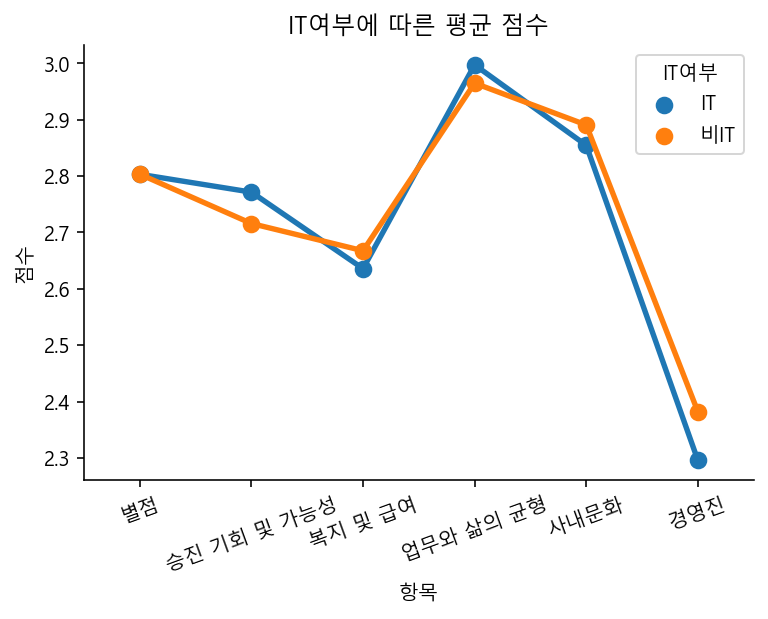

In [84]:
pointplot('IT여부')

- radar plot
    - 비IT 직군의 경영진 점수가 살짝 더 높아보이긴 하지만
    - point plot으로 볼때보다 두 그룹간의 큰 차이가 안보인다.
    - 통계검정으로 비교 해보자    

In [55]:
# radar plot 생성함수 
def radarplot(hue=None):
    melted = melting_table(hue) # melting함수 사용
    grouped = melted.groupby([hue,'항목'])['점수'].mean().reset_index().sort_values('항목')

    categories = list(grouped['항목'].unique())
#     categories.remove('별점')
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2*np.pi, num=len(categories))
    
    plt.figure(figsize=(5,5))
    ax = plt.subplot(polar=True)

    plt.xticks(label_loc, labels=categories, fontsize=10)
    
    for h_val in grouped[hue].unique():
        cond = grouped[hue] == h_val
        grade = list(grouped[cond]['점수'])
        grade = [*grade, grade[0]]
        
        ax.plot(label_loc, grade, label=h_val, lw=1, marker='o', ms=4)
        ax.fill(label_loc, grade, alpha=0.1)
    
    ax.legend(loc='center')
    ax.set_title(f'{hue}에 따른 평균 점수', fontsize=13)


    plt.show()

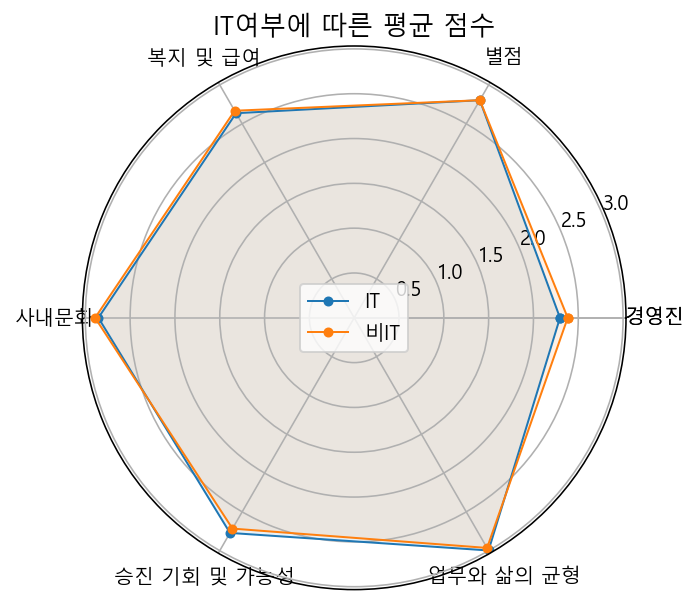

In [56]:
radarplot('IT여부')

- 비 모수적 검정
    - Wilcoxon-Mann-Whitney
    - 별점의 경우, 범주-순서 자료형
    - 참고 - https://bioinformaticsandme.tistory.com/111

In [57]:
# # levene test 함수 설정 (무시 - 모수검정용)
# def levene(hue_var, hue_val):
#     # 그룹 분할
#     cond = df[hue_var] == hue_val
#     df_a = df[cond][arr_scores]
#     df_b = df[~cond][arr_scores]
    
#     # 점수항목별 test
#     for col in arr_scores:
#         lev = stats.levene(df_a[col], df_b[col])
#         print(col)
#         if list(lev)[1] < 0.05: print('H1 채택 - 두 집단의 분산이 다르다.')
#         elif list(lev)[1] > 0.95: print('H0 채택  - 두 집단의 분산이 같다.')
#         else: print('두 집단의 분산이 다르다고 보기 어렵다.')
#         print(lev)
#         print('====='*15)   

In [58]:
# # 가설검정 함수 설정 (무시 - 모수검정용)
# def ttest(hue_var, hue_val):
#     cond = df[hue_var] == hue_val
#     df_a = df[cond][arr_scores]
#     df_b = df[~cond][arr_scores]
    
#     for col in arr_scores:
#         t_test = stats.ttest_ind(df_a[col], df_b[col], alternative='greater')
#         print(col)
        
#         if list(t_test)[1] < 0.05: print(f'H1 채택 - {hue_val} 그룹의 평점이 더 크다.')
#         elif list(t_test)[1] > 0.95: print(f'H0 채택 - {hue_val} 그룹의 평점이 더 작다.')
#         else: print(f'H0 기각실패 - {hue_val} 그룹의 평점이 더 크다고 보기 어렵다.')
            
#         print(t_test)
#         print('====='*15)   

In [66]:
# Mann-Whitney U test 함수 설정 (비모수 검정)
def mwutest(hue_var, hue_val, alter='greater'):
    cond = df[hue_var] == hue_val
    df_a = df[cond][arr_scores]
    df_b = df[~cond][arr_scores]
    
    for col in arr_scores:
        mwut = mannwhitneyu(df_a[col], df_b[col], alternative=alter)
        print(col)
        
        if alter == 'greater': a,b = '크다','작다'
        elif alter == 'less': a,b = '작다','크다'
            
        if list(mwut)[1] < 0.05: print(f'H1 채택 - {hue_val} 그룹의 평점이 더 {a}.')
        elif list(mwut)[1] > 0.95: print(f'H0 채택 - {hue_val} 그룹의 평점이 더 {b}.')
        else: print(f'H0 기각실패 - {hue_val} 그룹의 평점이 더 {a}고 보기 어렵다.')
            
        print(mwut)
        print('====='*15)   

In [69]:
mwutest('IT여부', 'IT', 'greater')

별점
H0 기각실패 - IT 그룹의 평점이 더 크다고 보기 어렵다.
MannwhitneyuResult(statistic=2692634900.5, pvalue=0.5952181241487665)
승진 기회 및 가능성
H1 채택 - IT 그룹의 평점이 더 크다.
MannwhitneyuResult(statistic=2774009082.0, pvalue=2.4689798336391016e-24)
복지 및 급여
H0 채택 - IT 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2657229939.0, pvalue=0.9999987221967673)
업무와 삶의 균형
H1 채택 - IT 그룹의 평점이 더 크다.
MannwhitneyuResult(statistic=2728951477.0, pvalue=7.888517337203747e-06)
사내문화
H0 채택 - IT 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2647650958.5, pvalue=0.9999999981397516)
경영진
H0 채택 - IT 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2591359137.0, pvalue=1.0)


### `전/현직원 구분`

- 전직원의 게시글수가 더 많다.
- 현직원이 기업리뷰를 작성하는 경우는 언제?

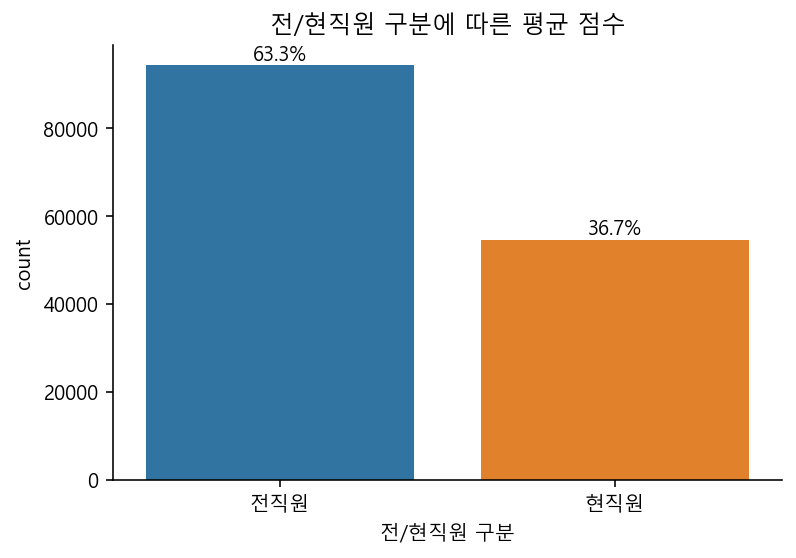

In [70]:
countplot('전/현직원 구분')

- 가설 : 전직원이 현직원에 비해 점수가 낮을 것이다.

- histplot
    - 전직원의 점수분포가 현직원보다 낮다.
    - 기업리뷰 사이트 이용자?
        1. 취업준비 
            - 학생(무료이용 가능) or 유료플랜 이용자 -> 리뷰 데이터 x
        2. 퇴사 후 이직준비(전직원) or 재직 중 이직준비 (현직원)
            - 리뷰데이터 작성시 1년간 리뷰데이터 확인가능
        3. 재직 중 (현직원)
            - 순수하게 다른 회사의 리뷰데이터를 보고 싶어서
    - 사이트 특성상 회사에 만족하며 다니는 사람이 리뷰를 작성하기 보다는, 불만이 있

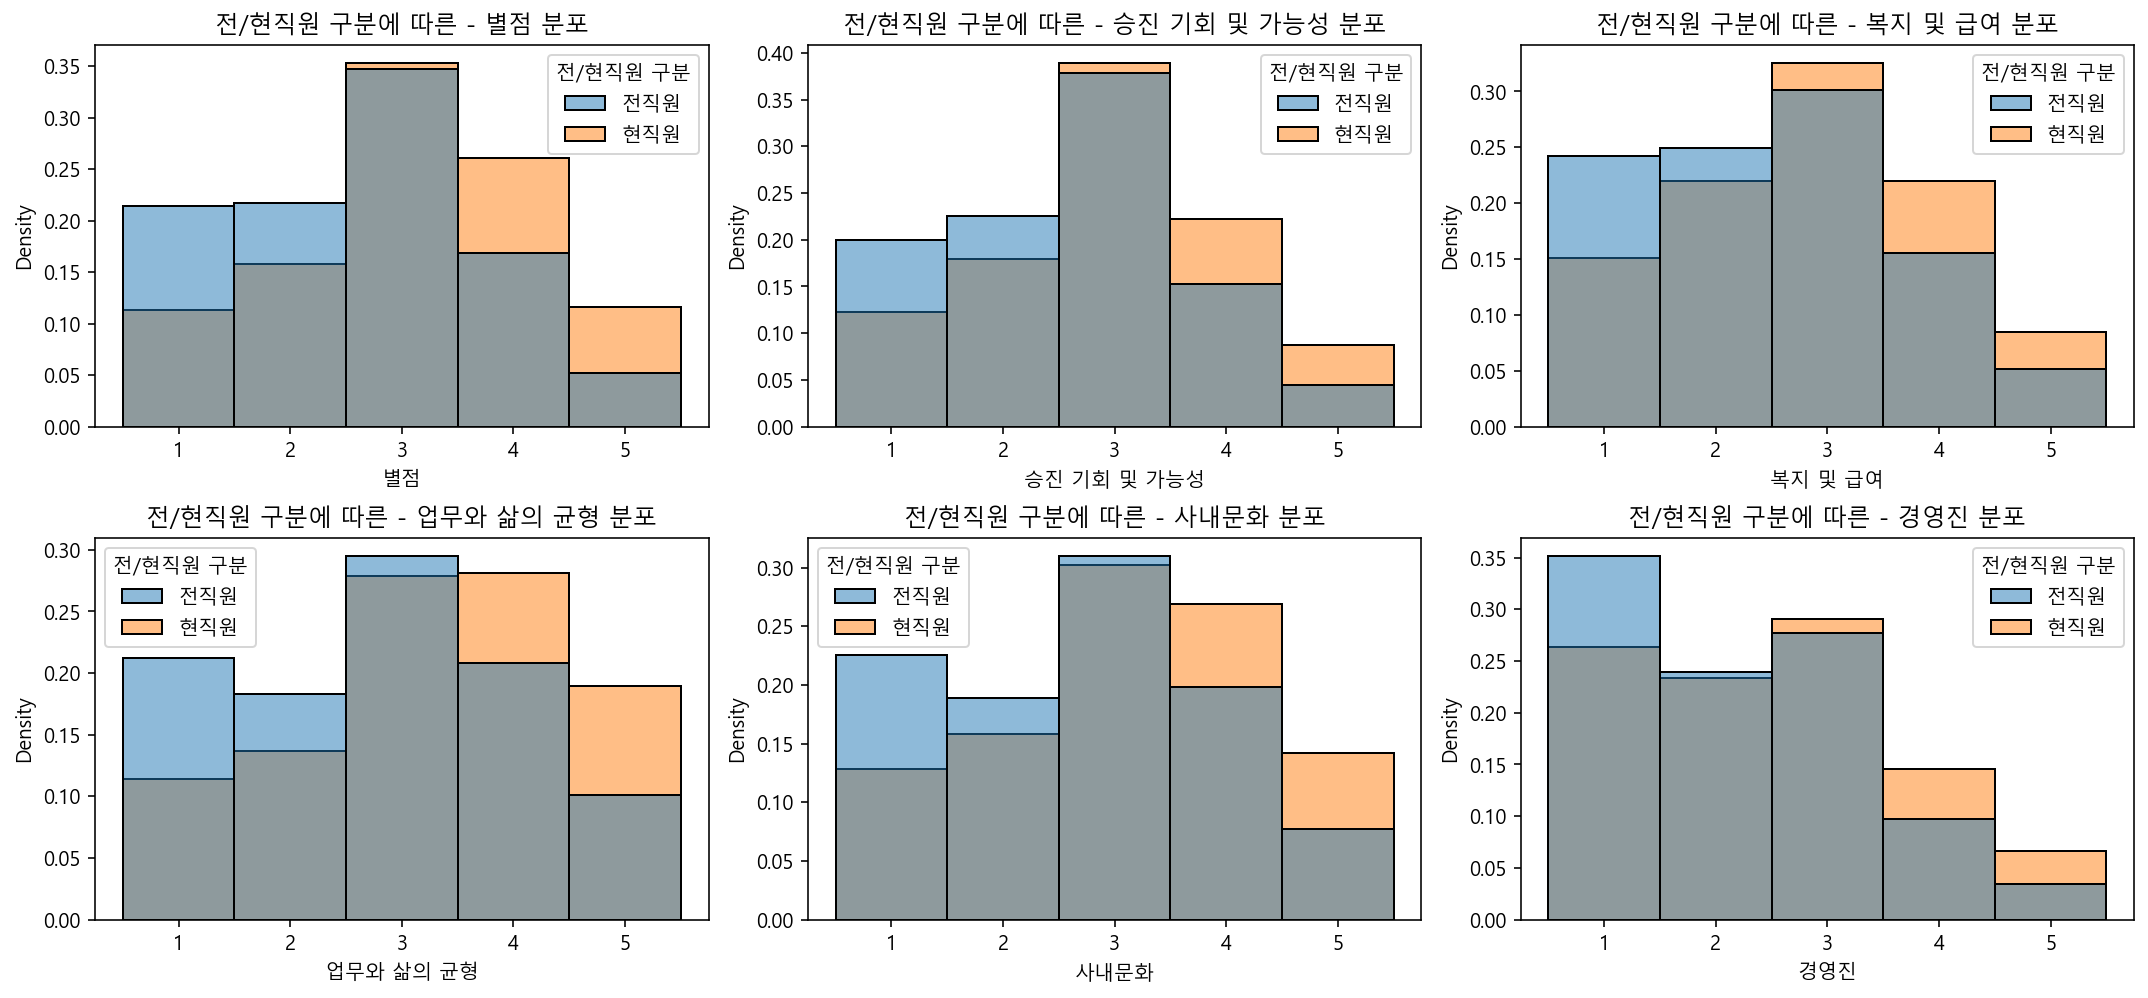

In [71]:
histplot('전/현직원 구분')

- point plot
    - 모든 점수에서 전직원의 평균평점이 상대적(현직원대비)으로 낮다.
    - 통계검정까지는 필요 없을 듯

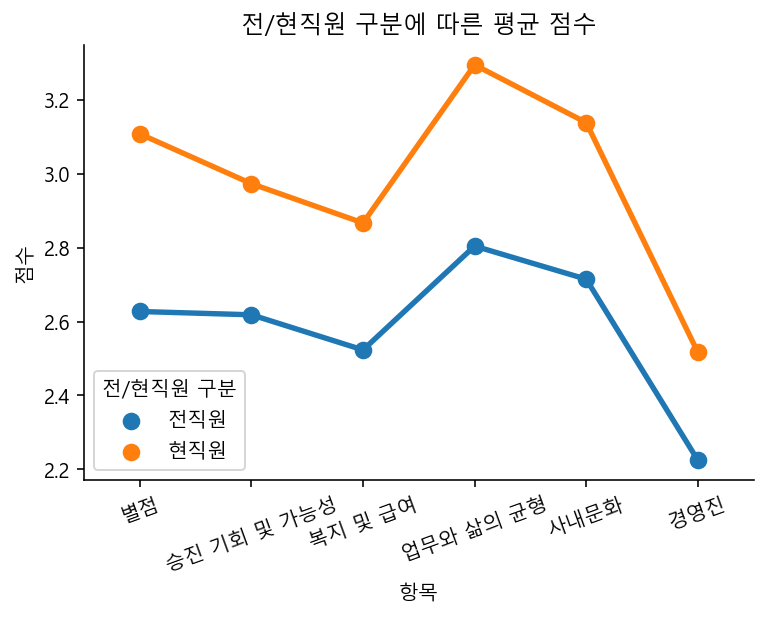

In [85]:
pointplot('전/현직원 구분')

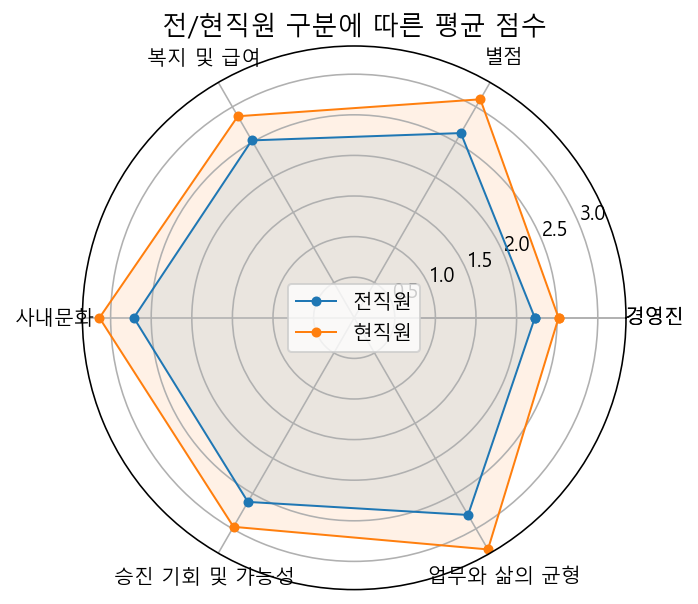

In [73]:
radarplot('전/현직원 구분')

In [74]:
mwutest('전/현직원 구분', '전직원', 'less')

별점
H1 채택 - 전직원 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=1984382730.0, pvalue=0.0)
승진 기회 및 가능성
H1 채택 - 전직원 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2122546085.5, pvalue=0.0)
복지 및 급여
H1 채택 - 전직원 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2152273694.0, pvalue=0.0)
업무와 삶의 균형
H1 채택 - 전직원 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2017721013.5, pvalue=0.0)
사내문화
H1 채택 - 전직원 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2083372770.5, pvalue=0.0)
경영진
H1 채택 - 전직원 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=2227281169.5, pvalue=0.0)


- 전현직에 따른 텍스트 데이터 분석

### `근무지역`

- 수도권 근무 여부
    - 가설 : 수도권 근무자의 만족도가 높을 것이다. 

In [78]:
# 수도권 여부 컬럼 생성
cond = df['근무지역'].isin(['서울','경기','인천'])
df['수도권여부'] = np.where(cond,'수도권','비수도권')
df.head(1)

,회사명,직군,전/현직원 구분,근무지역,작성년도,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부,수도권여부
index,,,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022,3,5,5,5,5,5,첫 회사였고 체계가 잘 잡혀있고 좋았었던 회사,"사내 카페,사내 안마실 등 사내 복지가 좋았음 칼퇴 보장함",나름 건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,좋은 사내문화가 만들어지면 좋을 것 같음,성장,추천,0,비IT,수도권


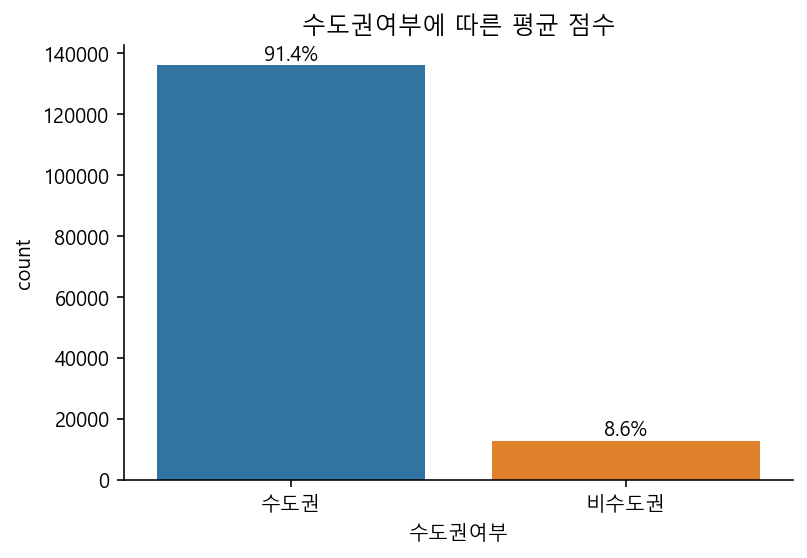

In [79]:
countplot('수도권여부')

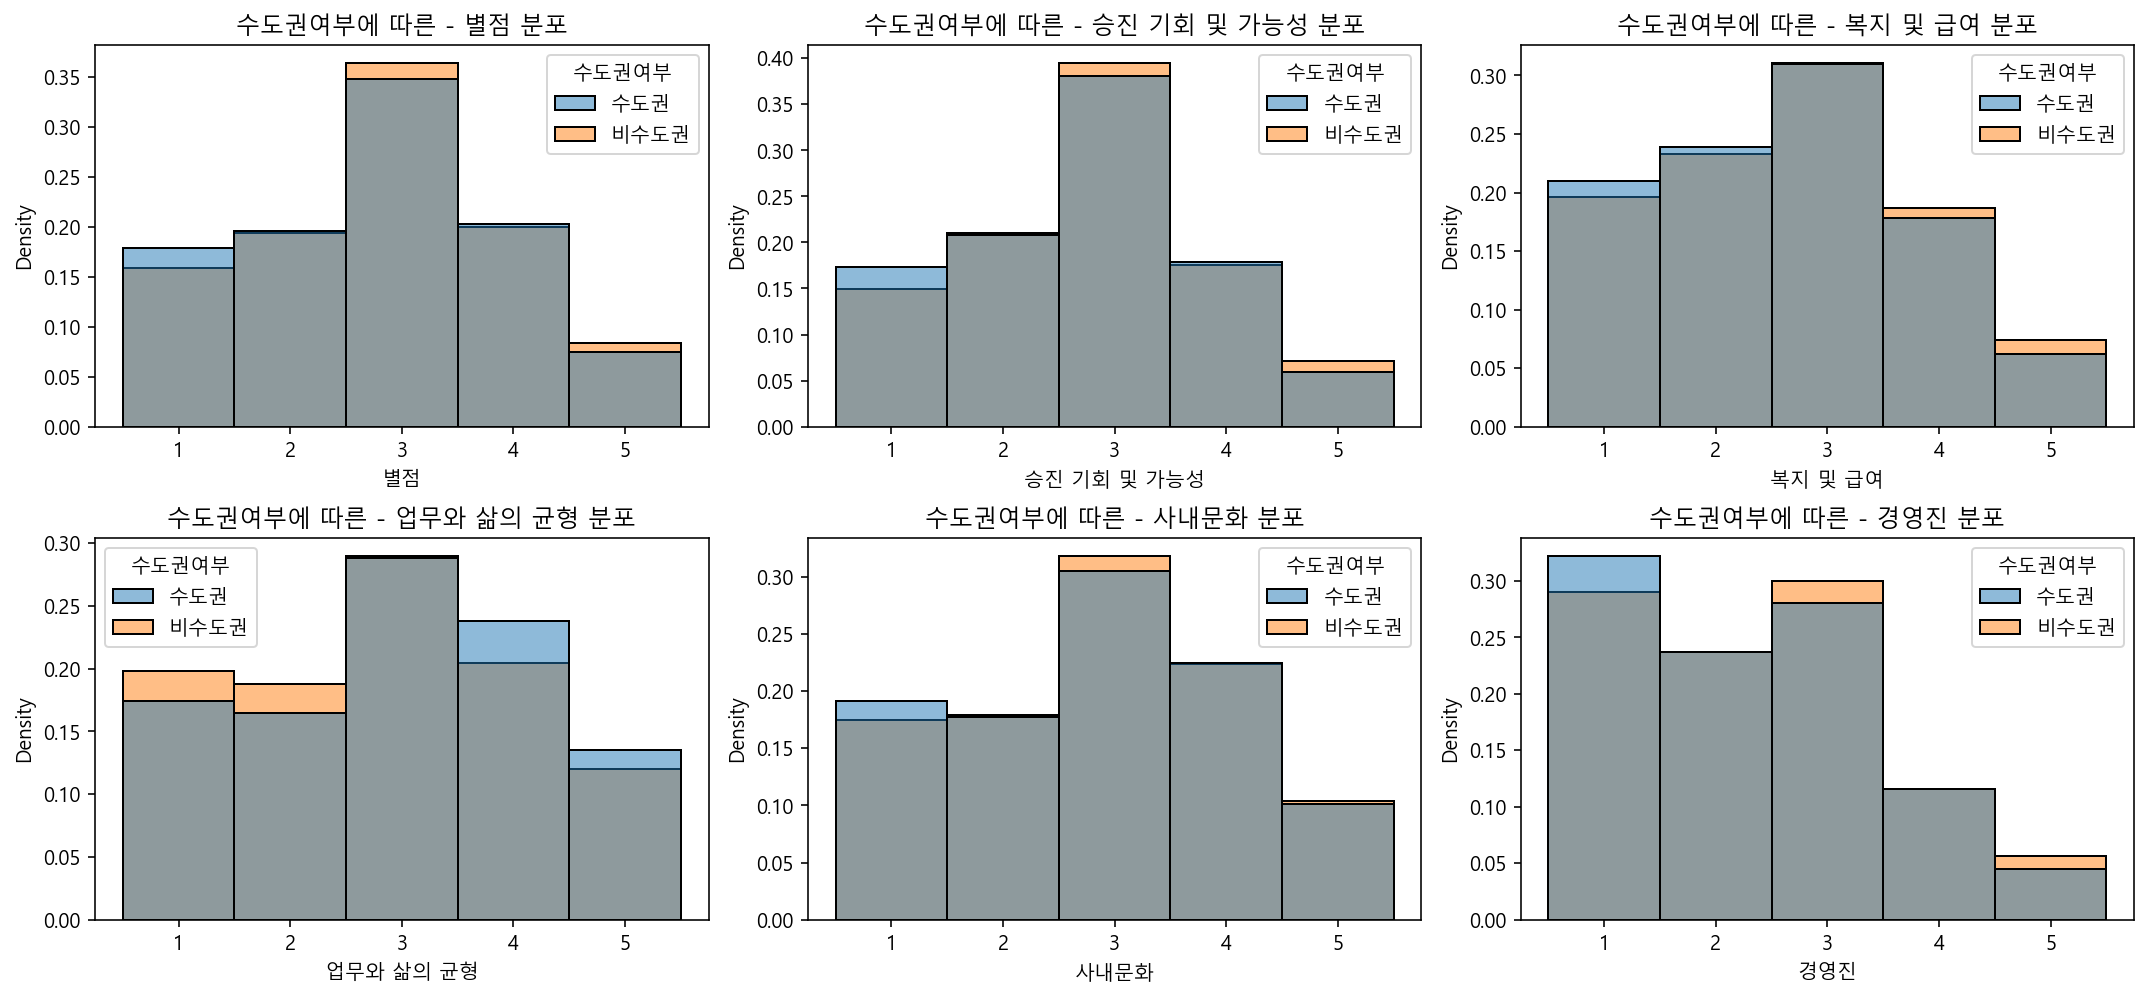

In [80]:
histplot('수도권여부')

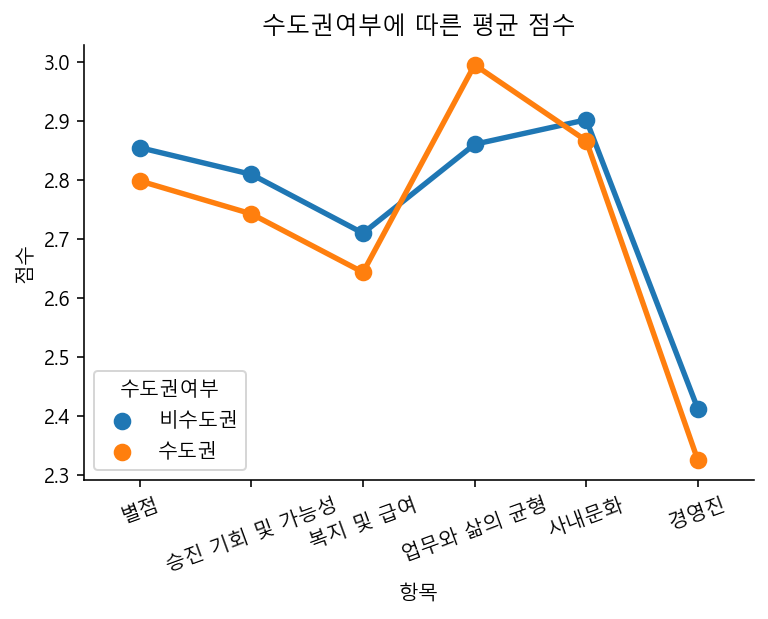

In [86]:
pointplot('수도권여부')

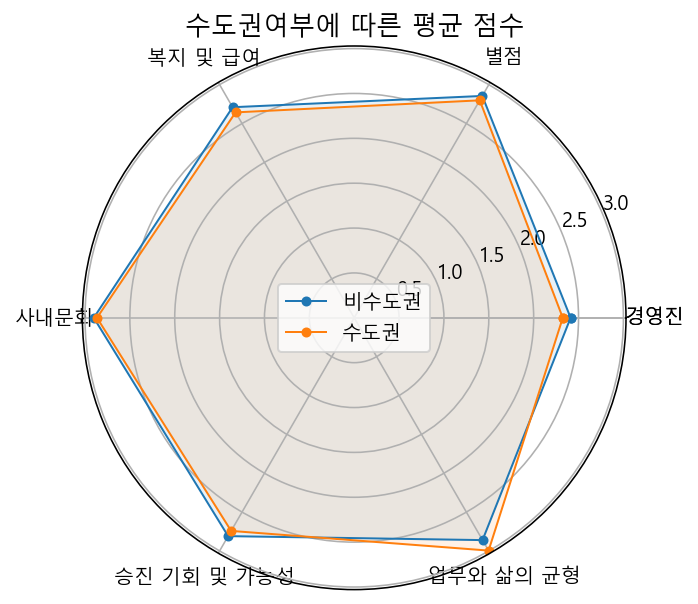

In [87]:
radarplot('수도권여부')

In [88]:
mwutest('수도권여부','수도권')

별점
H0 채택 - 수도권 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=848973587.0, pvalue=0.9999993501823736)
승진 기회 및 가능성
H0 채택 - 수도권 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=844452645.0, pvalue=0.9999999979649861)
복지 및 급여
H0 채택 - 수도권 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=844483565.0, pvalue=0.9999999970678314)
업무와 삶의 균형
H1 채택 - 수도권 그룹의 평점이 더 크다.
MannwhitneyuResult(statistic=923573622.0, pvalue=9.763713197405202e-32)
사내문화
H0 채택 - 수도권 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=857710428.0, pvalue=0.998010998561801)
경영진
H0 채택 - 수도권 그룹의 평점이 더 작다.
MannwhitneyuResult(statistic=835178198.0, pvalue=0.9999999999999989)


- 본사 근무여부

In [75]:
df_company_list

,회사명,본사위치,리뷰수,평균별점,평균연봉
index,,,,,
0,(주)티몬,서울,2022,2.8,4426
1,(주)위메프,서울,2003,2.6,2874
2,삼성에스디에스(주),서울,1801,3.5,8296
3,(주)엘지씨엔에스,서울,1759,3.1,6293
4,(주)엘지유플러스,서울,1747,3.2,6375
...,...,...,...,...,...
1196,제이엔테크놀러지(주),서울,30,2.4,3808
1197,지니키즈(주),서울,30,2.7,3212
1198,콤위즈(주),서울,30,2.4,2794


### `작성월` -> `작성년도`

In [167]:
# 결측치가 처리된 데이터셋 생성
cond = df['작성년도'] == 'unknown'
tmp = df[~cond]

In [168]:
# 연도별 테이블 생성 
grouped = df[['작성년도'] + arr_scores].groupby('작성년도').mean()
grouped = grouped.drop('unknown', axis=0)
grouped.T.style.background_gradient(cmap='summer_r')

작성년도,2014,2015,2016,2017,2018,2019,2020,2021,2022
별점,3.099745,2.902898,2.771078,2.602062,2.712987,2.766092,2.808410,2.803689,2.845849
승진 기회 및 가능성,3.000729,2.839175,2.786791,2.647938,2.690055,2.696475,2.716278,2.732662,2.783318
복지 및 급여,2.822986,2.713928,2.641940,2.515859,2.584185,2.636476,2.668360,2.639157,2.652815
업무와 삶의 균형,2.983234,2.826961,2.792853,2.752945,2.888962,3.001015,3.050624,3.114029,3.155437
사내문화,3.125866,2.961766,2.927016,2.786475,2.802816,2.841444,2.851832,2.833576,2.856436
경영진,2.523752,2.386360,2.334530,2.208994,2.282379,2.306922,2.354413,2.312107,2.334422


- 2017년도에 무슨일이? 
    - 2017년에 모든항목 평점 최저치 
- 업무와 삶의 균형 -> 2018년부터 매우 높아짐
- 경영진에 대한 불만이 가장 심한가?
    - 경영진 점수가 다른 점수들에 비해 유난히 낮다. 

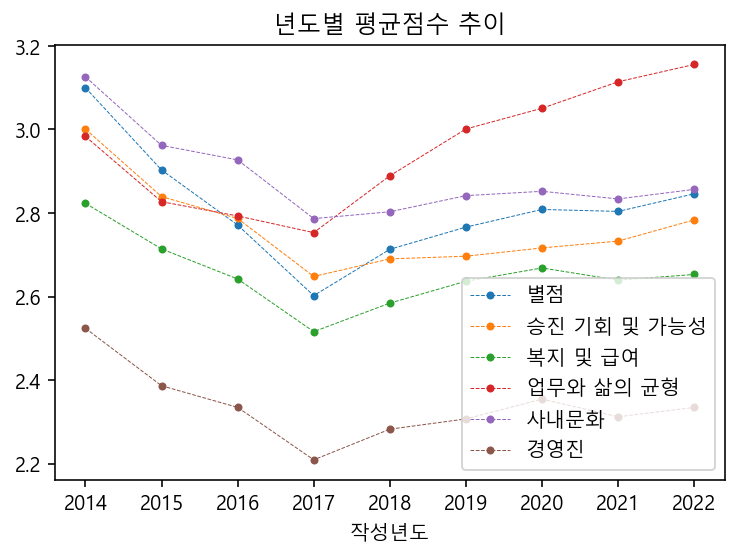

In [169]:
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--')
plt.title('년도별 평균점수 추이')
plt.show()

- IT vs 비 IT도 같은 경향인지 확인

In [173]:
cond = tmp['IT여부'] == 'IT'
tmp_it = tmp[cond]
tmp_nit = tmp[~cond]

In [174]:
# it
grouped = tmp_it[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T

작성년도,2014,2015,2016,2017,2018,2019,2020,2021,2022
별점,3.096429,2.883888,2.773794,2.583006,2.723499,2.777906,2.811287,2.804672,2.808117
승진 기회 및 가능성,3.003628,2.833150,2.792055,2.641484,2.717497,2.737000,2.751120,2.760258,2.801175
복지 및 급여,2.812297,2.709843,2.638363,2.496664,2.582503,2.619829,2.651388,2.619603,2.618726
업무와 삶의 균형,2.993508,2.813270,2.797254,2.757064,2.917497,3.022803,3.067035,3.139151,3.185831
사내문화,3.118388,2.920234,2.905892,2.760793,2.805697,2.827671,2.837787,2.821160,2.813635
경영진,2.477373,2.330162,2.288590,2.151688,2.263276,2.283491,2.325246,2.280827,2.265753


In [175]:
# 비 it
grouped = tmp_nit[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.T

작성년도,2014,2015,2016,2017,2018,2019,2020,2021,2022
별점,3.105544,2.934176,2.767031,2.628081,2.698229,2.750258,2.804782,2.802347,2.893072
승진 기회 및 가능성,2.995658,2.849087,2.778947,2.656752,2.651528,2.642164,2.672346,2.694976,2.760971
복지 및 급여,2.841683,2.720650,2.647269,2.542069,2.586547,2.658786,2.689759,2.665860,2.695478
업무와 삶의 균형,2.965264,2.849488,2.786296,2.747320,2.848900,2.971815,3.029932,3.079721,3.117398
사내문화,3.138945,3.030102,2.958491,2.821543,2.798772,2.859901,2.869541,2.850532,2.910002
경영진,2.604876,2.478828,2.402979,2.287245,2.309197,2.338323,2.391190,2.354822,2.420361


- 전반적인 추제는 비슷한데
    - 비 IT직군의 경우 2017년에 최저치 이후 모든항목의 평점이 시간이 지날수록 꾸준하게 상승하고 있는 반면, 
    - IT직군의 경우 업무와 삶의 균형(워라밸) 외에는 다시 하락세를 보인다. 

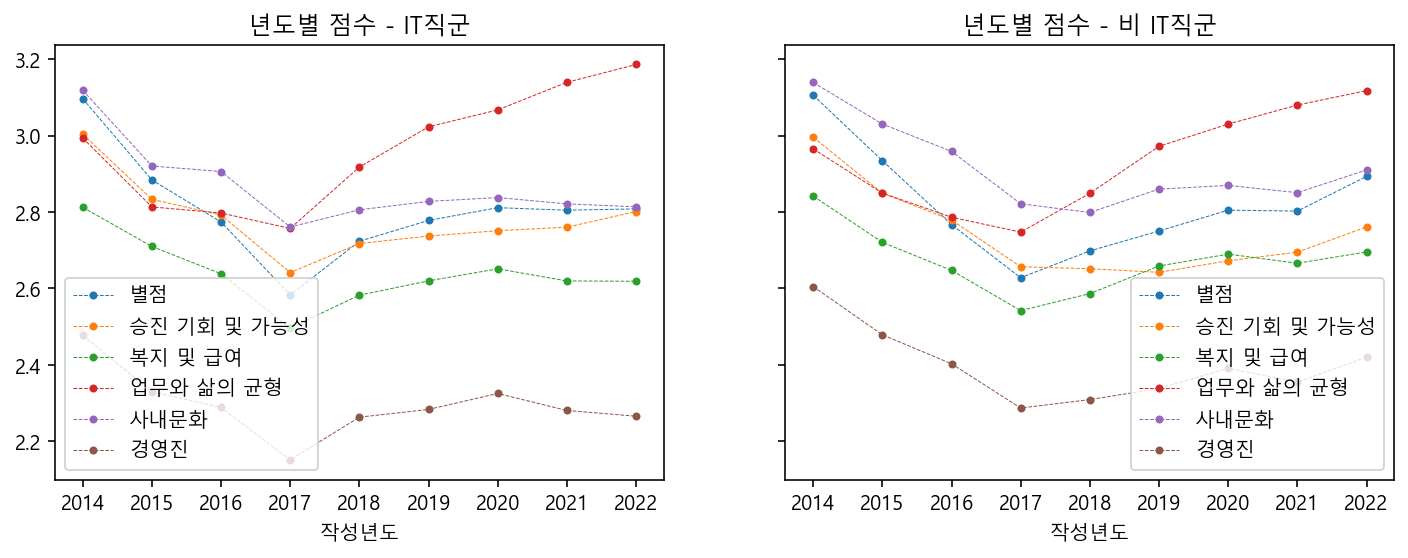

In [176]:
#시각화
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)

#it
grouped = tmp_it[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--', ax=ax[0])
ax[0].set_title('년도별 점수 - IT직군')

#non-it
grouped = tmp_nit[['작성년도'] + ['별점','승진 기회 및 가능성','복지 및 급여', '업무와 삶의 균형', '사내문화','경영진']].groupby('작성년도').mean()
grouped.plot(marker='o', ms=3 ,lw=0.5, ls='--', ax=ax[1])
ax[1].set_title('년도별 점수 - 비 IT직군')

plt.show()

### `1년 후 기업 전망`
- 성장 / 비슷 2가지 항목만 있다.
- 전체의 약 30%만이 1년뒤에 기업이 성장할 것이라고 작성   

In [188]:
cond = df['1년 후 기업 전망'] == 'un'
tmp = df[~cond]
tmp['1년 후 기업 전망'].unique()

array(['성장', '비슷', 'unknown'], dtype=object)

In [189]:
grouped = tmp[['1년 후 기업 전망'] + arr_scores].groupby('1년 후 기업 전망').mean()
grouped

,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진
1년 후 기업 전망,,,,,,
unknown,1.894934,2.045233,1.941915,2.438112,2.105202,1.471014
비슷,2.889293,2.789951,2.690338,3.038368,2.937294,2.380987
성장,3.893609,3.651500,3.559498,3.631797,3.799080,3.443483


- 1년 후 기업이 성장 할 것이다 라고 예상한 경우의 만족도가 그렇지 않은 그룹에 비해 만족도가 높다. 

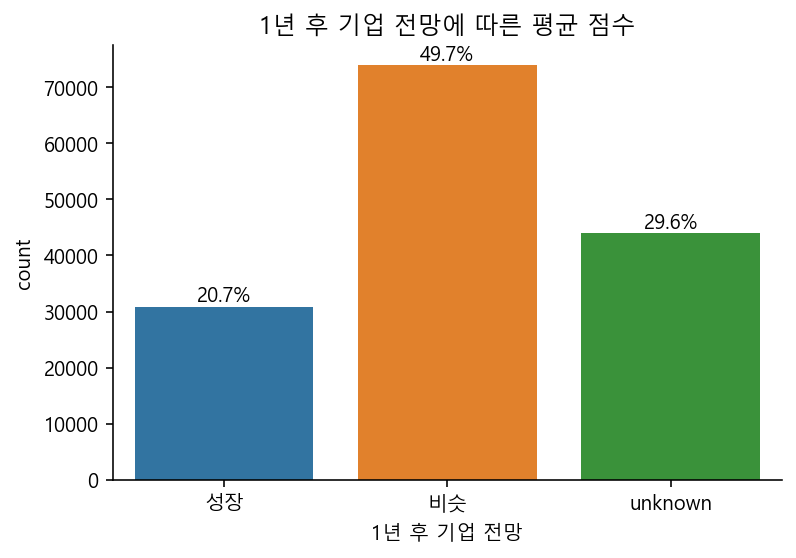

In [190]:
countplot('1년 후 기업 전망')

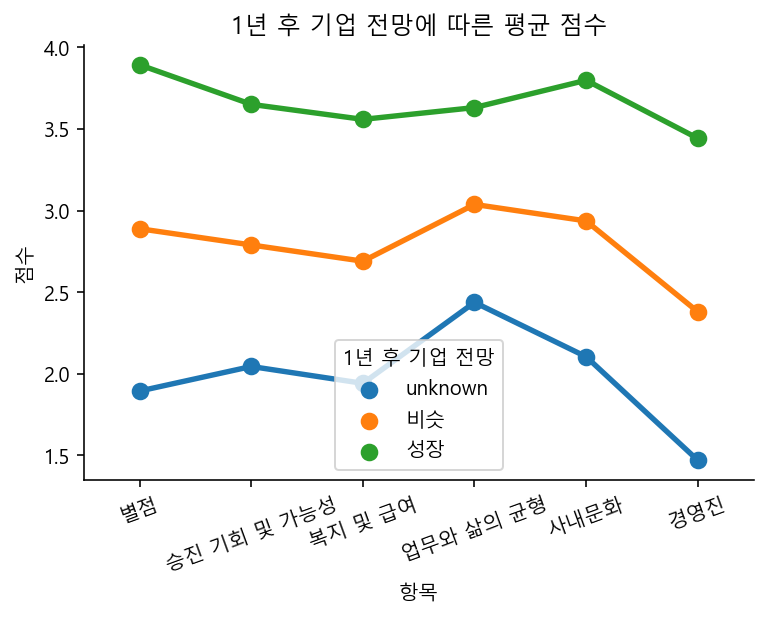

In [191]:
pointplot('1년 후 기업 전망')

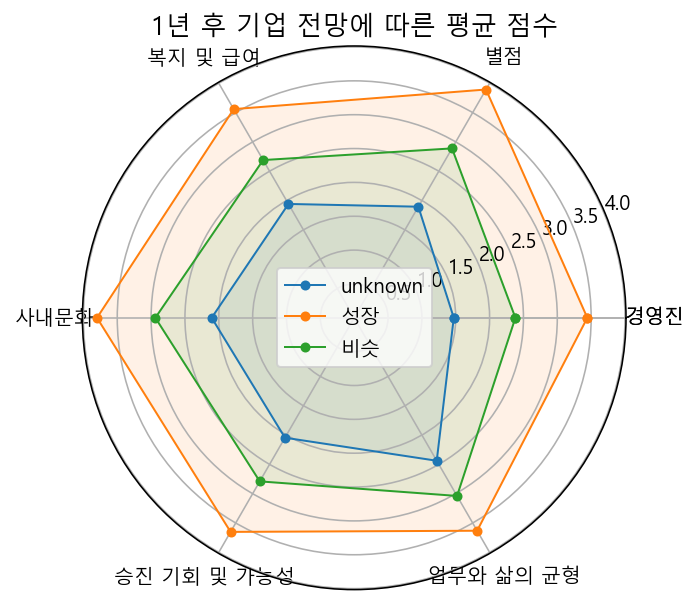

In [192]:
radarplot('1년 후 기업 전망')

###  기업 추천여부
- 1년 후 기업 전망과 기업 추천여부는 매우 비슷한 항목인 것 같은데?
    - 기업을 추천한 경우가 전체의 49.2%로, 1년 후 기업이 성장할 것이다라고 응답한 경우보다 높은 비율을 보인다.
    - 1년 뒤에도 기업이 비슷할 것 같은데 추천한 경우가 상당 수 있다. 
        -> 어떤 경우?

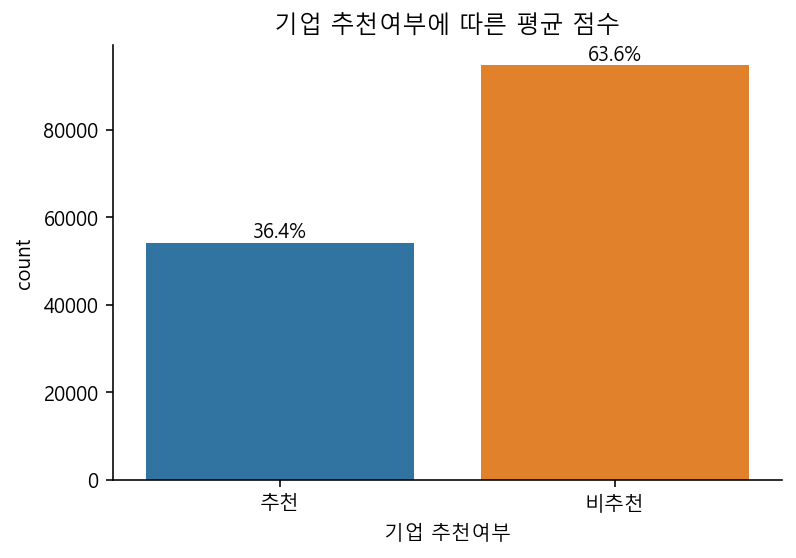

In [193]:
countplot('기업 추천여부')

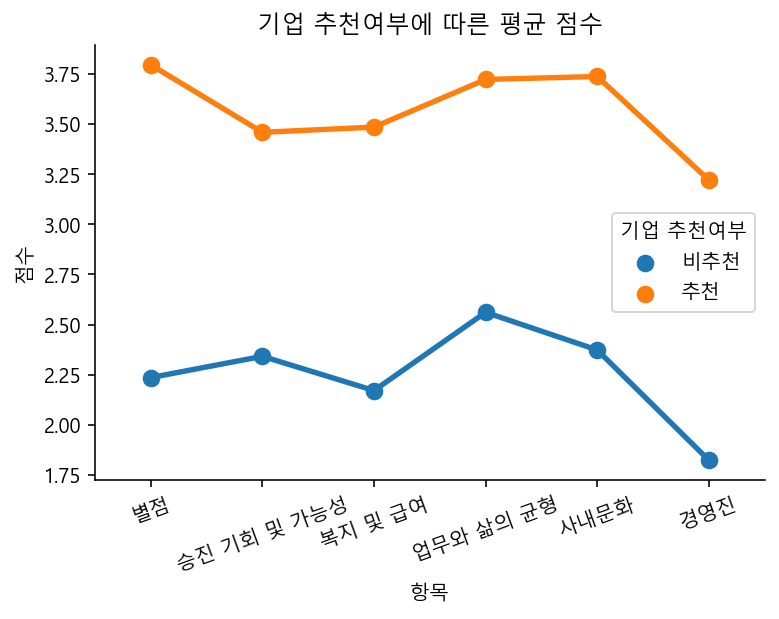

In [194]:
pointplot('기업 추천여부')

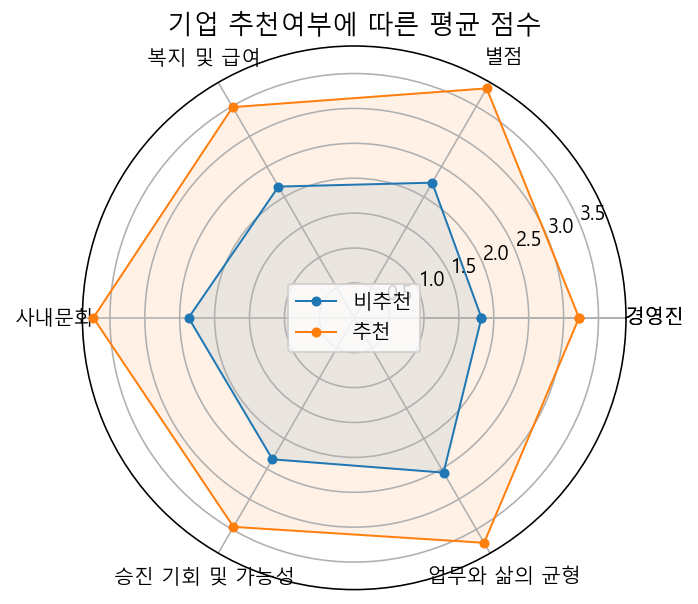

In [195]:
radarplot('기업 추천여부')

- 기업 비추천한 경우 
    - 1년 후 기업전망을 긍정적으로 보는 경우는 매우 적다(약 10%). 
- 기업을 추천한 경우 
    - 성장할 것이라고 예측한 경우와, 반대의 경우가 거의 50:50으로 비슷하다.
    - 기업의 전망과 기업의 추천여부는 크게 상관이 없단 말인가?
    - **각각의 케이스(4가지)에 따라 텍스트 분석을 통해 원이에 대해 파악해보자**

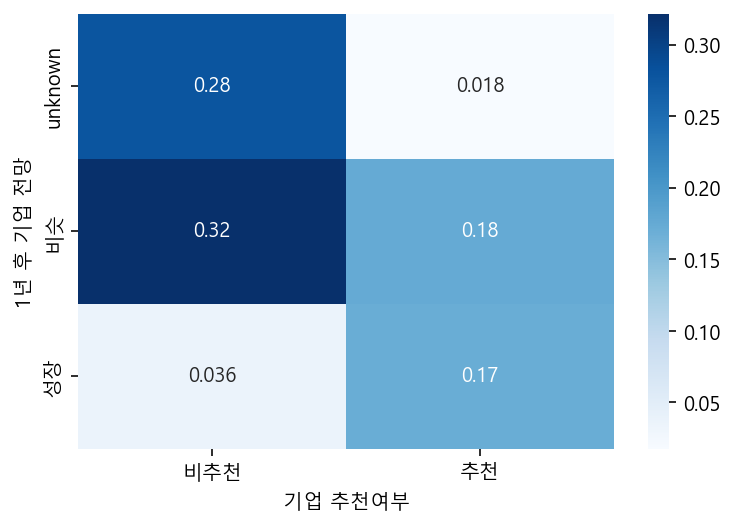

In [196]:
grouped = tmp[['1년 후 기업 전망', '기업 추천여부']].value_counts(['1년 후 기업 전망','기업 추천여부'])
grouped_ct = pd.crosstab(tmp['1년 후 기업 전망'], tmp['기업 추천여부'], normalize=True)
sns.heatmap(grouped_ct, annot=True, cmap='Blues');

### 게시글 추천 수

In [197]:
df['게시글 추천 수'].describe()

count    148813.000000
mean          1.652456
std           4.171619
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         624.000000
Name: 게시글 추천 수, dtype: float64

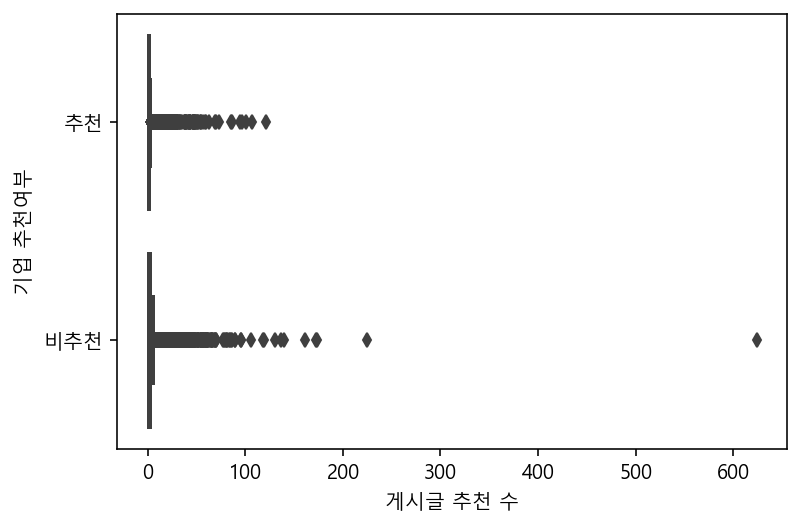

In [198]:
x='게시글 추천 수'
sns.boxplot(x=x, data=df, y='기업 추천여부');

- 추천 기능을 많이 사용하지 않는지 추천수 6개부터 이상치로 판단
- 이후 outlier 여부에 따른 텍스트 추가분석 필요 

In [199]:
Q1 = df['게시글 추천 수'].quantile(0.25)
Q3 = df['게시글 추천 수'].quantile(0.75)
IQR = Q3 - Q1

range1 = (Q1 - 1.5 *IQR)
range2 = (Q3 + 1.5 *IQR)

range1, range2

(-3.0, 5.0)

In [200]:
cond1 = df['게시글 추천 수'] < range1
cond2 = df['게시글 추천 수'] > range2

outlier = df[cond1 | cond2]
outlier

,회사명,직군,전/현직원 구분,근무지역,작성년도,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부,수도권여부
index,,,,,,,,,,,,,,,,,,,,
506,티몬,IT/인터넷,전직원,서울,2021,2,2,2,4,4,1,대표 바뀌고 맛탱이감그전까지는 기업문화 다들 웃으며 열심히 으쌰으쌰하는어딜가도 티몬...,it쪽은 칼퇴 영업부서만큼 강제야근강요나 실적강요 등은 없어서 버텨볼만함 사람들이 ...,걍 대표인민공화국 사람은 좋았다 허나 2020년 기준 분위기가 살벌해져서 그것도 아...,대표님 퇴사하세요 그게 이 회사의 조금이나마 도움을 주고 가는 길입니다 물론 그럴 ...,unknown,비추천,7,IT,수도권
617,티몬,영업/제휴,현직원,서울,2020,1,1,1,1,1,1,리뷰 공통되는 부분 있죠 같이 일하는 동료들만 좋구요 나머지는 뭐 이딴 내가 왜 이...,1 진짜 오늘 해야할 미션 완수하면 칼퇴 2 같이 일하는 동료들이 젊고 일이 힘들어...,1 100개 나열가능하지만 몇개만 적을게요 2 일단 가장 바뀌어야 단 한가지를 뽑으...,반성하세요 직원들이 행복해야 살아나고 성장합니다 제발 직원 존중 하세요 행사 뽑아내...,unknown,비추천,7,비IT,수도권
655,티몬,IT/인터넷,전직원,서울,2020,1,1,1,2,2,1,2019년 현 대표 오기전까진 분위기 좋았음 현대표 이xx온 이후로 줄 퇴사 분위기 엉망,기업의 장점이 없어져서 쓸말이 별로 없습니다 같이 일하는 사람들은 좋습니다,적자 인것은 알지만 이정도로 돈이 없나 싶음 동호회 거의 없애는거나 마찬가지이고 비...,애정이 많은 회사였는데 안타깝습니다 모든 직원들이 예민해져서 서로 싸우고 힘들어 합...,unknown,비추천,6,IT,수도권
711,티몬,서비스/고객지원,현직원,서울,2020,1,1,1,1,1,1,별 하나 조차도 아깝다 여기서 일하면서 자살 생각을 한 날이 단 하루도,눈을 씻고 찾아 봐도 없다 사람 취급을 전혀 못 받아서 놀랍고 굉장하다고 느낀다는거...,감옥에서도 화장실은 보내주더라 콜센터 주제에 고객한테 전화 한 번 걸려면 몇시간 동...,voc 보내면 적어도 답은 해줘라 한달 지나서라도 답 오면 그나마 다행임 대부분은 ...,unknown,비추천,7,비IT,수도권
748,티몬,디자인,전직원,서울,2020,1,1,1,2,2,1,티몬은 현 대표가 있기 전과 후로 나뉘어집니다 사람들과 문화는 정말 좋아요,윗사람 눈치 안보고 연차사용 가능사람들이 좋음문화가 좋음이전까지는 능력있는 사람들이...,복지가 사라짐대표가 새벽에 카톡으로 오더를 내리면 다음날 적용되어야 디자인실장은 대...,티몬 사람들이 말 중에 하나라도 들어주세요 제발요,unknown,비추천,7,비IT,수도권
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148783,트럼피아,IT/인터넷,전직원,서울,2017,1,1,2,3,1,1,별5 개짜리 기업평을 제외하고 이전 리뷰를 보면 이 회사를 이해할수,다양한 복지제도 액수는 케바케지만 분명히 존재하는 성과급,관리자 기술력 시간 일정 개념의 부재 성장가능성을 높이 볼수,제발 일정 먼저 정해놓고 개발자한테 던져 놓지 맙시다,unknown,비추천,8,IT,수도권
148784,트럼피아,IT/인터넷,전직원,서울,2017,2,2,3,3,1,1,미국에서 서비스하는 20세기 대표 한국 IT 중소기업,미국직원들과 함께 일하는 경험 휴가를 편하게 사용할 대화가 거의 조용한 분위기여서 ...,거의 대다수의 직원이 2년차가 안된다 그로인해 의사결정이 오래 있던 사람의 의견을 ...,직원들의 불만을 듣지만 수용을 하는지는 미지수 더이상 돈많이 벌수 있다는 것으로 직...,unknown,비추천,6,IT,수도권
148787,트럼피아,IT/인터넷,전직원,서울,2017,2,3,1,1,1,2,외국계 기업에 환상이 무색하리만치 한국적이고 꼰대적인,외국인과 기회가 많다 미국에서 몇개월간 근무할 기회가 주어지기도,하루 일하는 시간중 10분 쉬는것도 못마땅해함 암묵적으로 초과근무에 압박이 정치가 ...,정치질 직원들한테 힘을 실어주는것을 그만두고 회사의 성장에 도움이 될만한 직원들에게...,비슷,비추천,6,IT,수도권


In [201]:
norm = df[~(cond1 | cond2)]
norm

,회사명,직군,전/현직원 구분,근무지역,작성년도,별점,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,사내문화,경영진,총평,장점,단점,경영진에 바라는 점,1년 후 기업 전망,기업 추천여부,게시글 추천 수,IT여부,수도권여부
index,,,,,,,,,,,,,,,,,,,,
0,티몬,마케팅/시장조사,전직원,서울,2022,3,5,5,5,5,5,첫 회사였고 체계가 잡혀있고 좋았었던,사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함,건강 생각하는 흡연자였어서 당시 흡연하러 하루에 3번만 나갔는데 위에서 지적 받음,사내문화가 만들어지면 좋을 같음,성장,추천,0,비IT,수도권
1,티몬,영업/제휴,현직원,서울,2022,3,5,5,5,1,1,영업부서는 그나마 운영이 잘되나 별 의미없는 콘텐츠 제작관련한 리소스가 들어감 방향...,연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...,동기부여도지 않는 모든것 2 3년 다니고 경험쌓기는 MD권한 대표의 공감대없는 언행...,신규사업을 하려면 청사진부터 방향성에 맞게 가이드라인을 만들고 인사팀의 권한좀강화시...,비슷,추천,0,비IT,수도권
2,티몬,디자인,현직원,서울,2022,2,1,1,2,1,1,하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진,리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...,있던 복지도 사라지는 중잦은 조직개편과 경영진 교체리더와 시니어들 대거 퇴사로 주니...,사업에 비전과 그를 실현시킬 구체적인 방향을 제시해주길 원합니다모두가 함께 으쌰으쌰...,unknown,비추천,0,비IT,수도권
3,티몬,영업/제휴,현직원,서울,2022,3,4,3,4,4,3,개인적으로는 만족스럽습니다 코로나 기간동안 재택도 꽤오래함,큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임,뭔가 시도를 많이함 이커머스 특성상 그래야하는건 알지만 부담스러움,그냥 뭐 돈을 많이주면 좋을듯 그거말고 바라는거없음 건물도 깔끔하고,비슷,추천,0,비IT,수도권
4,티몬,IT/인터넷,전직원,기타,2022,3,3,3,3,3,3,무난히 회사입니다 나쁘지 않습니다,적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다,힘든 점은 업무의 강도 시간적인 여유가 없을 때입니다,워라벨과 균형이 조금씩 점진적으로 이루어졌으면 좋겠습니다,비슷,추천,0,IT,비수도권
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148816,한국옐로우페이지,마케팅/시장조사,전직원,서울,2015,1,2,2,2,3,2,임원들이 정말 직원들 복지 아예 신경안쓰는 같아요 직원들이 만족을 해야 돌아가죠 정말,회식을 자주 참가하지 않아도 별 말 보너스가 회사에 비하면 있는편입니다 커피를 자주...,단순보고가 많고 회사의 효율성이 떨어짐 임원들과의 대화가 되지 않고 사원들은 임원들...,직원들 복지에 조금만 신경 써주시구요 임원분들 진짜 위에서만 그렇게 나눠 먹지 마세...,비슷,비추천,0,비IT,수도권
148817,한국옐로우페이지,서비스/고객지원,전직원,서울,2015,2,3,2,3,5,1,정부의 지원을 받아 국내 중소기업의 홍보를 도와주는 회사정부지원에 의존도가 높다,국내의 다양한 중소기업을 만나볼 있다는 것과 업계 내에서는 인지도가 편인 것이 장점...,직원들의 평균연령이 높고 늘 정체되어 분위기 가족회사라서 직원들이 암묵적으로 가족의...,누가봐도 불필요한 잉여인력은 분위기를 저해시키는 요소입니다 성장에 해가되는 것에 대...,비슷,비추천,3,비IT,수도권
148818,한국옐로우페이지,마케팅/시장조사,전직원,서울,2015,2,2,2,2,2,2,공공기관 아래에서 중소기업을 돕는 업무는 진행하는,공공기관 협회 업무에 대해서 직간접적인 경험을,직원의 희생에 대해서 당연시하는 경향 퇴사가 많은,회사를 발전시키고 싶다면 우선 직원의 삶이 발전해야 한다는 것을 알아야,비슷,비추천,3,비IT,수도권


- 비추천의 경우 게시글 추천 수가 상대적으로 많다.
    - 긍정적인 내용에 추천을 누르기 보단, 부정적인 내용에 추천을 더 많이 누른다고 봐야?


In [202]:
# 이상치 포함
df.groupby('기업 추천여부')['게시글 추천 수'].describe()

,count,mean,std,min,25%,50%,75%,max
기업 추천여부,,,,,,,,
비추천,94672.0,2.029005,4.769031,0.0,0.0,1.0,2.0,624.0
추천,54141.0,0.994016,2.716863,0.0,0.0,0.0,1.0,121.0


In [203]:
# 이상치 제거 후
norm.groupby('기업 추천여부')['게시글 추천 수'].describe()

,count,mean,std,min,25%,50%,75%,max
기업 추천여부,,,,,,,,
비추천,85174.0,1.015251,1.371105,0.0,0.0,0.0,2.0,5.0
추천,52415.0,0.665840,1.107599,0.0,0.0,0.0,1.0,5.0


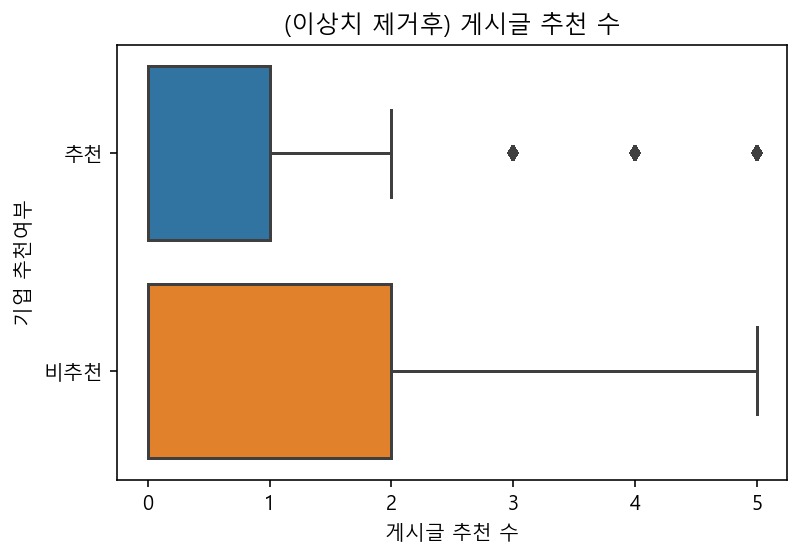

In [204]:
sns.boxplot(x='게시글 추천 수', data=norm,  y='기업 추천여부')
plt.title('(이상치 제거후) 게시글 추천 수');

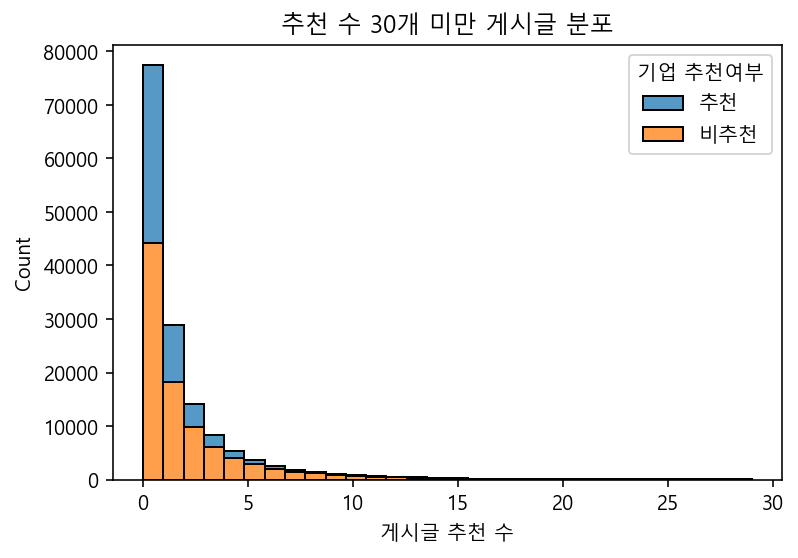

In [212]:
sns.histplot(x='게시글 추천 수', data=df[df['게시글 추천 수']<30], bins=30, hue='기업 추천여부', multiple='stack')
plt.title('추천 수 30개 미만 게시글 분포');

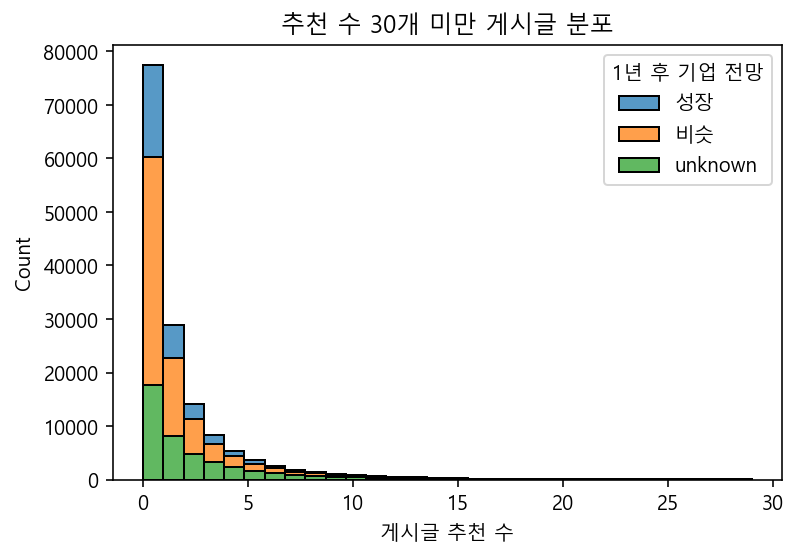

In [211]:
sns.histplot(x='게시글 추천 수', data=df[df['게시글 추천 수']<30], bins=30, hue='1년 후 기업 전망', multiple='stack')
plt.title('추천 수 30개 미만 게시글 분포');

## 리뷰 데이터(텍스트) 분석

### 전처리

In [151]:
# 전처리 함수
def clean_sentencese(text):
    pattern = '[\r|\n]'            # 개행문자 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))

    pattern = '<[^>]*>'            # html tag 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
                  
    pattern = '([ㄱ-ㅎㅏ-ㅣ])+'    # 한글 자음, 모음 제거 
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = '[^\w\s]'            # 특수기호 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    pattern = re.compile(r'\s+')   # 이중 space 제거
    text = re.sub(pattern=pattern, repl=' ', string=str(text))
    
    return text

In [152]:
# 전처리 실행
df['총평'] = df['총평'].map(clean_sentencese)
df['장점'] = df['장점'].map(clean_sentencese)
df['단점'] = df['단점'].map(clean_sentencese)
df['경영진에 바라는 점'] = df['경영진에 바라는 점'].map(clean_sentencese)

In [153]:
# 불용어 제거 함수
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = '것 수 사람이 너무 경우가 심함 좀 되는 한다 함 그 많음 안 대부분 경우 조금 하는 없는 더 대한 없고 없는 기업 다른 가능 다니기 것 비해 편 않음 따라 많이 업무 하지만 그래도 없음 있으며 또한 나름 회사가 또한 좋은 좋고 좋음 좋다 그리고 때문에 다 수 있는 할 일할 회사 다닐 수 있음 있다 매우 및 등 잘 있어 있어서 있고'
    stops = list(stops.split())
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [154]:
# 불용어 제거 실행
df['총평'] = df['총평'].apply(remove_stopwords)
df['장점'] = df['장점'].apply(remove_stopwords)
df['단점'] = df['단점'].apply(remove_stopwords)
df['경영진에 바라는 점'] = df['경영진에 바라는 점'].apply(remove_stopwords)

In [155]:
df['총평']

index
0                                      첫 회사였고 체계가 잡혀있고 좋았었던
1         영업부서는 그나마 운영이 잘되나 별 의미없는 콘텐츠 제작관련한 리소스가 들어감 방향...
2                     하루가 다르게 바뀌는 조직이전의 좋았던 기억마저 퇴색되게하는 경영진
3                         개인적으로는 만족스럽습니다 코로나 기간동안 재택도 꽤오래함 
4                                       무난히 회사입니다 나쁘지 않습니다 
                                ...                        
148816      임원들이 정말 직원들 복지 아예 신경안쓰는 같아요 직원들이 만족을 해야 돌아가죠 정말
148817        정부의 지원을 받아 국내 중소기업의 홍보를 도와주는 회사정부지원에 의존도가 높다 
148818                          공공기관 아래에서 중소기업을 돕는 업무는 진행하는
148819                                       중소기업과 가까이 일하는 
148820                           외국인 이면 들어가기 힘듭니다 마케팅 관심 필요
Name: 총평, Length: 148813, dtype: object

### TF
- mecab 쓰고 싶은데 윈도우에서는 mecab 안된다고 한다. 
- 첫 5문장 분석시 OKT보다 한나눔이 조금더 자연스럽게 명사가 끊어져서 한나눔으로 사용

In [157]:
tmp = df.copy()

#### 형태소 분석기 테스트 - 한나눔

In [158]:
hannanum=Hannanum()  
han_tmp = tmp['장점'][:5]
han_tmp

index
0                       사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함
1    연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...
2    리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...
3               큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임
4                    적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다 
Name: 장점, dtype: object

In [159]:
han_tmp.apply(lambda x:hannanum.nouns(x))

index
0                            [카페, 안마, 사내, 복지, 칼퇴, 보장함]
1    [연차사용, 자유, 하반기, 시작, 전사, 리모트워크, 자율성, 극대화, 영업, 본...
2     [리모트워크, 준비, 중, 6월, 전사, 재택근무, 예정젊, 직원들, 팀바팀, 동료들]
3                    [인센티브, 연차, 자유사용, 자유도, 수평적, 기업문화임]
4                            [적당, 워라벨, 평균적, 급여, 시간, 나]
Name: 장점, dtype: object

#### 형태소 분석기 테스트 - Okt (구 트위터)

In [160]:
okt = Okt()
okt_tmp = tmp['장점'][:5]
okt_tmp

index
0                       사내 카페 사내 안마실 사내 복지가 좋았음 칼퇴 보장함
1    연차사용 자유 하반기부터 시작되는 전사 리모트워크로 인한 자율성 극대화 영업의 본인...
2    리모트워크 준비 중으로 6월부터 전사 재택근무 예정젊은 직원들 팀바팀이지만 함께 버...
3               큰 인센티브는 없지만 연차 자유사용 자유도가 높고 수평적인 기업문화임
4                    적당한 워라벨과 평균적인 급여와 시간 나를 돌아보게 합니다 
Name: 장점, dtype: object

In [161]:
okt_tmp.apply(lambda x:okt.nouns(x))

index
0                      [사내, 카페, 사내, 사내, 복지, 칼퇴, 보장, 함]
1    [연차, 사용, 자유, 하반기, 시작, 전사, 리, 모트, 워, 자율성, 대화, 영...
2         [리, 모트, 워, 준비, 중, 전사, 재택근무, 예정, 직원, 팀바팀, 동료]
3               [인센티브, 연차, 자유, 사용, 자유도, 수평, 기업, 문화, 임]
4                                  [워, 라벨, 평균, 급여, 시간]
Name: 장점, dtype: object

### 워드크라우드 시각화 

In [162]:
%%time
col = '장점'
tmp[col] = tmp[col].apply(lambda x:hannanum.nouns(x))

Wall time: 7min 4s


In [78]:
%%time
장점 = Counter(list(itertools.chain(*list(tmp['장점']))))

Wall time: 489 ms


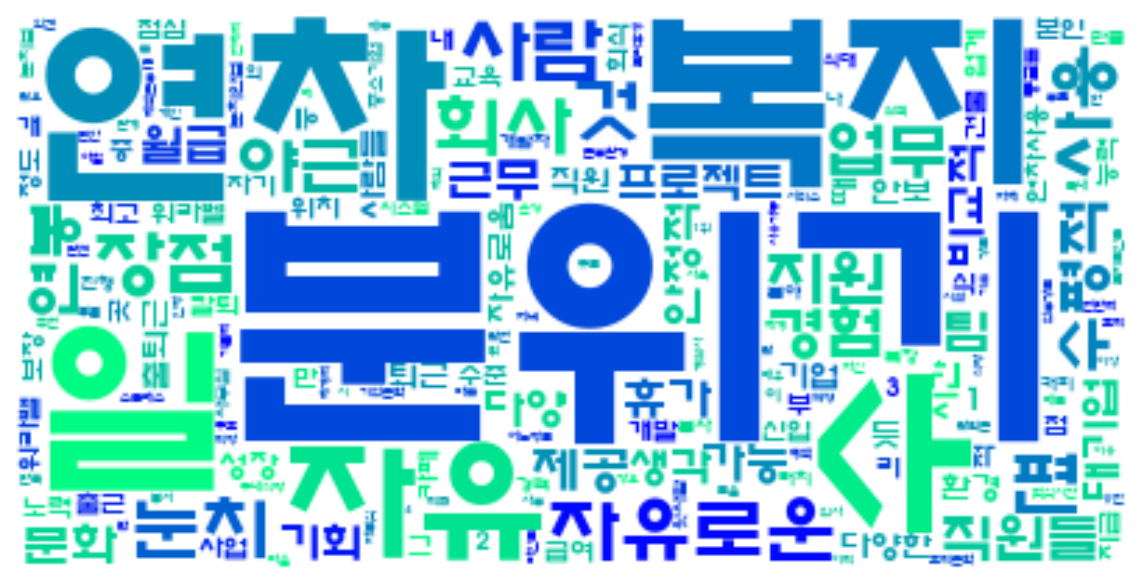

Wall time: 952 ms


In [81]:
%%time


In [85]:
%%time
col = '단점'
tmp[col] = tmp[col].apply(lambda x:hannanum.nouns(x))

Wall time: 11min 21s


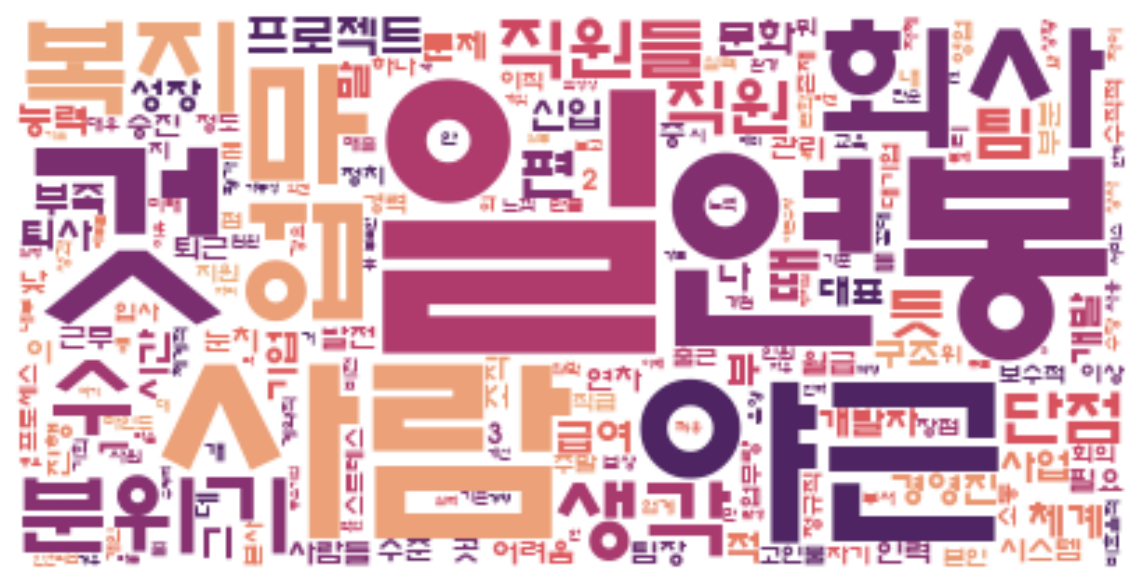

In [98]:
단점 = Counter(list(itertools.chain(*list(tmp['단점']))))

wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap='flare').generate_from_frequencies(단점)
plt.figure(figsize=(10,15))
plt.axis('off') # 그래프 축 제거
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
%%time
col = '총평'
tmp[col] = tmp[col].apply(lambda x:hannanum.nouns(x))

In [ ]:
총평 = Counter(list(itertools.chain(*list(tmp['총평']))))

wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap='flare').generate_from_frequencies(총평)
plt.figure(figsize=(10,15))
plt.axis('off') # 그래프 축 제거
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
%%time
col = '경영진에 바라는 점'
tmp[col] = tmp[col].apply(lambda x:hannanum.nouns(x))

In [ ]:
경영진 = Counter(list(itertools.chain(*list(tmp['총평']))))

wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap='flare').generate_from_frequencies(경영진)
plt.figure(figsize=(10,15))
plt.axis('off') # 그래프 축 제거
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [102]:
sorted(단점.items(), key=lambda x:x[1], reverse=True)

[('일', 32872),
 ('연봉', 25356),
 ('사람', 21007),
 ('것', 20813),
 ('야근', 17125),
 ('회사', 15964),
 ('업무', 14096),
 ('복지', 13211),
 ('분위기', 11947),
 ('수', 11071),
 ('생각', 10846),
 ('직원들', 10798),
 ('직원', 9333),
 ('단점', 8547),
 ('팀', 8505),
 ('듯', 8067),
 ('때', 7899),
 ('편', 7777),
 ('프로젝트', 7728),
 ('문화', 5986),
 ('체계', 5980),
 ('1', 5741),
 ('급여', 5729),
 ('말', 5608),
 ('개발', 5159),
 ('시간', 5091),
 ('신입', 4986),
 ('사업', 4980),
 ('경영진', 4940),
 ('성장', 4933),
 ('부족', 4821),
 ('부', 4743),
 ('그', 4552),
 ('적', 4525),
 ('능력', 4432),
 ('기업', 4408),
 ('퇴사', 4395),
 ('개발자', 4275),
 ('문제', 4223),
 ('나', 4164),
 ('대표', 4126),
 ('구조', 4069),
 ('사람들', 4050),
 ('진행', 4018),
 ('필요', 3991),
 ('데', 3982),
 ('2', 3977),
 ('연차', 3897),
 ('근무', 3860),
 ('곳', 3844),
 ('월급', 3828),
 ('발전', 3792),
 ('이', 3759),
 ('부분', 3607),
 ('인력', 3566),
 ('어려움', 3501),
 ('눈치', 3475),
 ('시스템', 3402),
 ('팀장', 3401),
 ('조직', 3352),
 ('퇴근', 3327),
 ('관리', 3315),
 ('낮', 3306),
 ('수준', 3232),
 ('3', 3214),
 ('승진', 3213),
 ('중', 3

In [ ]:
%%time
arr_reviews = ['총평', '장점','단점','경영진에 바라는 점']
for col in arr_reviews:
    tmp[col] = tmp[col].apply(lambda x:hannanum.nouns(x))

In [ ]:
총평 = Counter(list(itertools.chain(*list(tmp['총평']))))
장점 = Counter(list(itertools.chain(*list(tmp['장점']))))
단점 = Counter(list(itertools.chain(*list(tmp['단점']))))
경영진 = Counter(list(itertools.chain(*list(tmp['경영진에 바라는 점']))))

In [ ]:
#장점
wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap='winter').generate_from_frequencies(장점)
plt.figure(figsize=(10,15))
plt.axis('off') # 그래프 축 제거
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

In [ ]:
#단점
wordcloud = WordCloud("./font/HYTBRB.TTF", background_color='white', colormap='winter').generate_from_frequencies(단점)
plt.figure(figsize=(10,15))
plt.axis('off') # 그래프 축 제거
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# 정리

# 고찰
- 형태소 분석기의 stemming 기능을 써서 조금더 자연스럽게 사용할 수 있겠다.
  - 형태소 분석기로 명사, 동사 먼저 추출한다음(시간도 오래 걸리고) 불용어 처리를 나중에 한다.
    - 지금은 전처리, 불용어 처리 먼저하고 바로 TF-IDF -> 모델 분석
    - 혹은 형태소 분석기까지 써서 장단점에 대한 워드 클라우드 분석
  - (참고:https://www.youtube.com/watch?v=R3jlcyehc50)

- PC - RAM 부족으로 전체에 대한 tf-idf 진행이 어려웠음
  - 이 경우 어떻게 문제를 해결하는지 확인하고, 해결법 찾아 학습 해볼 것
  - 분할해서 처리하고, 결과를 업데이트 해줘야 하는지?

- 보다 다양한 인사이트 발견을 위해서는, 다양한 소스에서 다양한 데이터들을 추가로 붙이고 처리하고 해야할 듯 하다. 